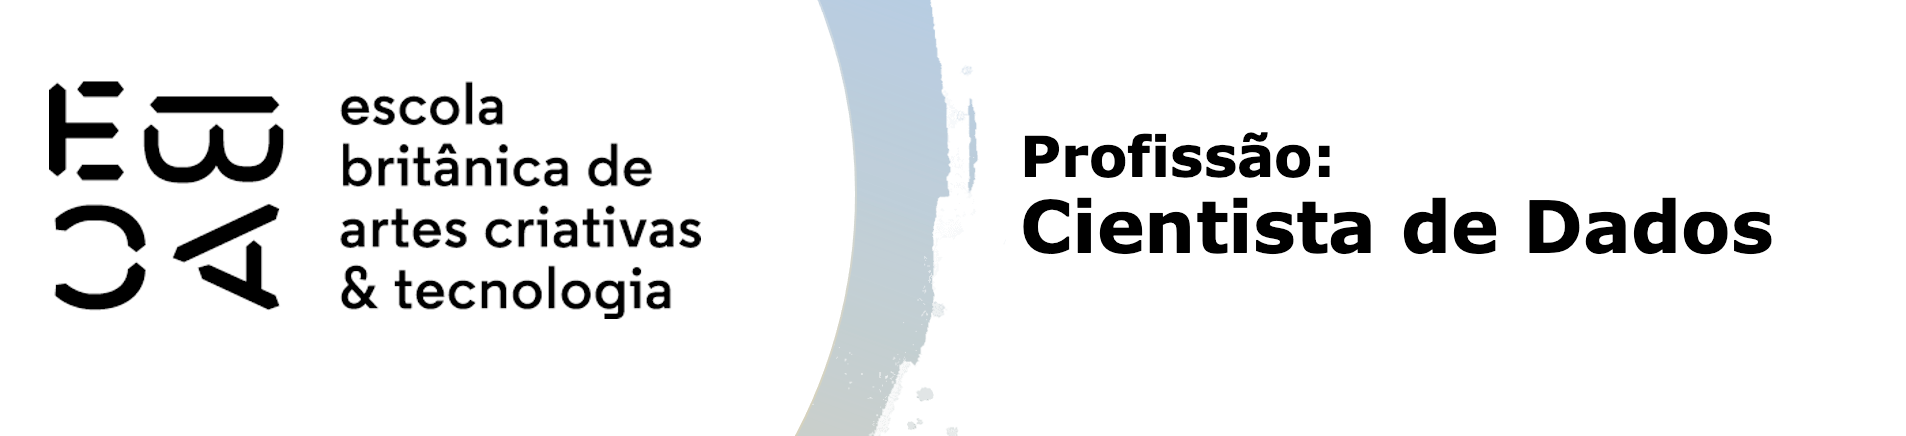

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [2]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# Nome do arquivo
filename = 'credit_scoring.ftr'

try:
    # 1. Carregar o conjunto de dados
    df = pd.read_feather(filename)

    # 2. Garantir que 'data_ref' seja do tipo datetime
    df['data_ref'] = pd.to_datetime(df['data_ref'])

    # 3. Identificar os 3 meses mais recentes para a separação OOT
    
    # Ordenar o DataFrame por data (boa prática)
    df = df.sort_values(by='data_ref')

    # Encontrar todas as datas de referência (safras) únicas
    periodos_unicos = df['data_ref'].dt.to_period('M').unique()
    
    # --- CORREÇÃO AQUI ---
    # Usar a função sorted() para ordenar o PeriodArray
    datas_safra = sorted(periodos_unicos)
    # --- FIM DA CORREÇÃO ---

    # Selecionar as 3 últimas safras para OOT
    safras_oot = datas_safra[-3:]
    
    # Obter a data de início do período OOT (o primeiro dia da primeira safra OOT)
    data_inicio_oot = safras_oot[0].to_timestamp()

    print(f"Safras únicas encontradas: {len(datas_safra)}")
    print(f"Safras de validação (OOT) selecionadas: {safras_oot}")
    print(f"Período de treino será anterior a: {data_inicio_oot.strftime('%Y-%m-%d')}")
    print("-" * 30)

    # 4. Separar os dados em Treino e Validação (OOT)
    
    # O conjunto de treino (in-time) contém dados ANTERIORES à primeira safra OOT
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    
    # O conjunto OOT contém dados DAS 3 ÚLTIMAS safras
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()

    # 5. Definir as variáveis (features, target e colunas a dropar)
    
    # Variável alvo (target) - o que queremos prever
    target = 'mau'

    # Colunas que não devem ser usadas como variáveis explicativas
    cols_to_drop = ['data_ref', 'index', 'mau']

    # As features são todas as colunas restantes
    features = [col for col in df.columns if col not in cols_to_drop]

    # 6. Criar os conjuntos X (features) e y (target)
    X_train = df_train[features]
    y_train = df_train[target]

    X_oot = df_oot[features]
    y_oot = df_oot[target]

    # 7. Imprimir resultados da separação
    print(f"Shape do DataFrame original: {df.shape}")
    print("-" * 30)
    print("TREINO (IN-TIME):")
    print(f"  Período: {df_train['data_ref'].min().strftime('%Y-%m-%d')} a {df_train['data_ref'].max().strftime('%Y-%m-%d')}")
    print(f"  Shape X_train: {X_train.shape}")
    print(f"  Shape y_train: {y_train.shape}")
    print(f"  Taxa de 'mau': {y_train.mean():.4f}")
    print("-" * 30)
    print("VALIDAÇÃO (OUT-OF-TIME):")
    print(f"  Período: {df_oot['data_ref'].min().strftime('%Y-%m-%d')} a {df_oot['data_ref'].max().strftime('%Y-%m-%d')}")
    print(f"  Shape X_oot:   {X_oot.shape}")
    print(f"  Shape y_oot:   {y_oot.shape}")
    print(f"  Taxa de 'mau': {y_oot.mean():.4f}")
    print("-" * 30)
    print("Features selecionadas para modelagem:")
    print(features)

except FileNotFoundError:
    print(f"Erro: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo: {e}")

Safras únicas encontradas: 15
Safras de validação (OOT) selecionadas: [Period('2016-01', 'M'), Period('2016-02', 'M'), Period('2016-03', 'M')]
Período de treino será anterior a: 2016-01-01
------------------------------
Shape do DataFrame original: (750000, 15)
------------------------------
TREINO (IN-TIME):
  Período: 2015-01-01 a 2015-12-01
  Shape X_train: (600000, 12)
  Shape y_train: (600000,)
  Taxa de 'mau': 0.0611
------------------------------
VALIDAÇÃO (OUT-OF-TIME):
  Período: 2016-01-01 a 2016-03-01
  Shape X_oot:   (150000, 12)
  Shape y_oot:   (150000,)
  Taxa de 'mau': 0.1467
------------------------------
Features selecionadas para modelagem:
['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
import pandas as pd

# Carregue o arquivo .ftr (você precisa ter o 'pyarrow' instalado)
df = pd.read_feather("credit_scoring.ftr")

# Salve como .csv
df.to_csv("credit_scoring.csv", index=False)

In [7]:
import pandas as pd
import numpy as np

# Configurar opções de exibição do pandas para melhor visualização das tabelas
# (Isso ajuda a formatar as tabelas na impressão)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 100)

# Nome do arquivo CSV que você enviou
filename = 'credit_scoring.csv'

try:
    # Tenta carregar o arquivo CSV
    df = pd.read_csv(filename)
    
    print("==================================================================")
    print("               Análise Descritiva Básica da Base")
    print("==================================================================\n")

    # 1. Total de Linhas
    print("--- 1. Dimensões da Base (Tabela) ---")
    # Cria um DataFrame para mostrar as dimensões de forma organizada
    dimensoes = pd.DataFrame({
        'Descrição': ['Total de Linhas (Registros)', 'Total de Colunas (Variáveis)'],
        'Valor': [df.shape[0], df.shape[1]]
    })
    print(dimensoes.to_string(index=False))
    print("\n" + "="*66 + "\n")

    # 2. Número de Linhas por Mês (data_ref)
    print("--- 2. Contagem de Registros por Mês (Safra) ---")
    if 'data_ref' in df.columns:
        # Garante que a coluna de data seja do tipo datetime
        df['data_ref'] = pd.to_datetime(df['data_ref'])
        
        # Agrupa os dados por Mês ('M') e conta os registros
        safra_counts = df['data_ref'].dt.to_period('M').value_counts().sort_index()
        
        # Formata a saída como uma tabela DataFrame
        safra_df = safra_counts.to_frame(name='Contagem')
        safra_df.index.name = 'Safra (Mês)'
        print(safra_df)
    else:
        print("AVISO: Coluna 'data_ref' não encontrada.")
    print("\n" + "="*66 + "\n")

    # 3. Descritiva Univariada
    
    # Define colunas que são identificadores e não devem ser analisadas
    cols_to_exclude = ['data_ref', 'index']
    
    # --- Análise da Variável Alvo (Target) ---
    print("--- 3.1. Análise da Variável Alvo (mau) ---")
    if 'mau' in df.columns:
        print(f"Valores Nulos: {df['mau'].isnull().sum()}")
        
        # Calcula contagens absolutas
        counts = df['mau'].value_counts(dropna=False)
        # Calcula contagens percentuais
        percents = (df['mau'].value_counts(normalize=True, dropna=False) * 100)
        
        # Cria a tabela de distribuição
        dist_df_mau = pd.DataFrame({
            'Contagem': counts,
            'Percentual (%)': percents
        })
        dist_df_mau.index.name = 'Valor'
        print(dist_df_mau)
    else:
        print("AVISO: Coluna 'mau' (alvo) não encontrada.")
    print("\n" + "="*66 + "\n")

    # --- Análise de Variáveis Quantitativas ---
    
    # Seleciona colunas numéricas (int e float)
    quant_cols = df.select_dtypes(include=[np.number]).columns
    # Remove as colunas de exclusão e a variável alvo
    quant_cols = [col for col in quant_cols if col not in cols_to_exclude + ['mau']]
    
    print(f"--- 3.2. Análise Univariada: Variáveis Quantitativas ({len(quant_cols)} colunas) ---")
    if not quant_cols:
        print("Nenhuma variável quantitativa encontrada (excluindo identificadores).")
    else:
        # Usa o método .describe() para obter as estatísticas básicas
        desc_quant = df[quant_cols].describe().T
        
        # Adiciona colunas extras à tabela do describe:
        # Contagem de nulos
        desc_quant['nulos'] = df[quant_cols].isnull().sum()
        # Percentual de nulos
        desc_quant['%_nulos'] = (desc_quant['nulos'] / len(df)) * 100
        # Contagem de valores únicos
        desc_quant['unicos'] = df[quant_cols].nunique()
        
        # Reordena as colunas da tabela para melhor leitura
        cols_order = ['count', 'nulos', '%_nulos', 'unicos', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
        print(desc_quant[cols_order])
        
    print("\n" + "="*66 + "\n")

    # --- Análise de Variáveis Qualitativas ---
    
    # Seleciona colunas de texto ('object') ou booleanas ('bool')
    qual_cols = df.select_dtypes(include=['object', 'bool']).columns
    # Exclui a variável 'mau' (já analisada)
    qual_cols = [col for col in qual_cols if col not in ['mau']]
    
    print(f"--- 3.3. Análise Univariada: Variáveis Qualitativas ({len(qual_cols)} colunas) ---")
    if not qual_cols:
        print("Nenhuma variável qualitativa encontrada (excluindo 'mau').")
    else:
        # Itera (loop) sobre cada coluna qualitativa
        for col in qual_cols:
            print(f"\n--- Tabela: '{col}' ---")
            
            nulos = df[col].isnull().sum()
            print(f"Valores Nulos: {nulos} ({(nulos / len(df)) * 100:.2f}%)")
            
            unicos = df[col].nunique()
            print(f"Valores Únicos: {unicos}")
            
            print("\nDistribuição (Absoluta e Percentual):")
            
            # Cria a tabela de frequência (contagem e percentual)
            counts = df[col].value_counts(dropna=False)
            percents = (df[col].value_counts(normalize=True, dropna=False) * 100)
            
            dist_df = pd.DataFrame({
                'Contagem': counts,
                'Percentual (%)': percents
            })
            
            print(dist_df.sort_index())
            print("-" * 40)
            
except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo: {e}")

               Análise Descritiva Básica da Base

--- 1. Dimensões da Base (Tabela) ---
                   Descrição  Valor
 Total de Linhas (Registros) 750000
Total de Colunas (Variáveis)     15


--- 2. Contagem de Registros por Mês (Safra) ---
             Contagem
Safra (Mês)          
2015-01         50000
2015-02         50000
2015-03         50000
2015-04         50000
2015-05         50000
2015-06         50000
2015-07         50000
2015-08         50000
2015-09         50000
2015-10         50000
2015-11         50000
2015-12         50000
2016-01         50000
2016-02         50000
2016-03         50000


--- 3.1. Análise da Variável Alvo (mau) ---
Valores Nulos: 0
       Contagem  Percentual (%)
Valor                          
False    691357           92.18
True      58643            7.82


--- 3.2. Análise Univariada: Variáveis Quantitativas (5 colunas) ---
                          count   nulos  %_nulos  unicos     mean      std    min     25%     50%  \
qtd_filhos      

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [8]:
import pandas as pd
import numpy as np

# Configurar opções de exibição do pandas para melhor visualização
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format) # 4 casas decimais para taxas
pd.set_option('display.width', 100)

filename = 'credit_scoring.csv'

def analisar_grupo(df, col_grupo, col_alvo='mau_int'):
    """
    Função auxiliar para agrupar dados e calcular a taxa de inadimplência (mau).
    """
    try:
        # Agrupa pela coluna, calcula a média (taxa de mau) e a contagem
        grouped_df = df.groupby(col_grupo)[col_alvo].agg(['mean', 'count'])
        
        # Renomeia colunas para clareza
        grouped_df = grouped_df.rename(columns={'mean': 'taxa_mau_%', 'count': 'n_registros'})
        
        # Converte a média (ex: 0.07) para percentual (ex: 7.0)
        grouped_df['taxa_mau_%'] = grouped_df['taxa_mau_%'] * 100
        
        # Ordena pela taxa de inadimplência para facilitar a visualização
        print(grouped_df.sort_values(by='taxa_mau_%', ascending=False))
        
    except Exception as e:
        print(f"Erro ao analisar '{col_grupo}': {e}")
    print("-" * 60)

try:
    df = pd.read_csv(filename)
    
    # --- 1. Preparação ---
    # É mais fácil trabalhar com 'mau' como 0 (bom) e 1 (mau)
    df['mau_int'] = df['mau'].astype(int)
    
    # Identificar variáveis (excluindo IDs e os alvos originais)
    cols_to_exclude = ['data_ref', 'index', 'mau', 'mau_int']
    
    # Variáveis qualitativas (categóricas)
    qual_cols = df.select_dtypes(include=['object', 'bool']).columns
    qual_cols = [col for col in qual_cols if col not in cols_to_exclude]
    
    # Variáveis quantitativas (numéricas)
    quant_cols = df.select_dtypes(include=[np.number]).columns
    quant_cols = [col for col in quant_cols if col not in cols_to_exclude]
    
    # Algumas numéricas têm poucos valores (são discretas)
    # É melhor tratá-las como categóricas na análise bivariada
    discrete_cols = ['qtd_filhos', 'qt_pessoas_residencia']
    
    # As contínuas são as que vamos binar (fatiar)
    continuous_cols = [col for col in quant_cols if col not in discrete_cols]
    
    print("==================================================================")
    print("            Análise Bivariada vs. Taxa de 'mau'")
    print("==================================================================\n")

    # --- 2. Análise: Categóricas vs. 'mau' ---
    print("--- 2.1. Variáveis Categóricas (e Discretas) vs. 'mau' ---")
    
    # Loop por todas as colunas qualitativas + discretas
    for col in qual_cols + discrete_cols:
        print(f"\nAnálise: '{col}' vs. 'mau'")
        analisar_grupo(df, col)

    # --- 3. Análise: Contínuas vs. 'mau' ---
    print("\n" + "="*66 + "\n")
    print("--- 3.1. Correlação: Variáveis Contínuas vs. 'mau' ---")
    
    # Calcula a correlação de Pearson
    correlation_matrix = df[continuous_cols + ['mau_int']].corr()
    
    # Mostra apenas a correlação com a variável alvo
    target_correlation = correlation_matrix['mau_int'].drop('mau_int')
    print("Correlação de Pearson com a taxa de 'mau':")
    print(target_correlation.sort_values(ascending=False))
    print("-" * 60)

    print("\n--- 3.2. Análise por Faixas (Binning): Contínuas vs. 'mau' ---")

    # Análise de 'idade'
    print(f"\nAnálise: 'idade' (em faixas) vs. 'mau'")
    # Cria 10 faixas de idade de tamanho igual
    df['idade_bin'] = pd.cut(df['idade'], bins=10, precision=0)
    analisar_grupo(df, 'idade_bin')

    # Análise de 'renda'
    print(f"\nAnálise: 'renda' (em decis/quantis) vs. 'mau'")
    # 'renda' é muito assimétrica, então usamos quantis (q=10 para decis)
    # 'duplicates=drop' é necessário caso haja muitos valores iguais nos cortes
    df['renda_bin'] = pd.qcut(df['renda'], q=10, duplicates='drop')
    analisar_grupo(df, 'renda_bin')

    # Análise de 'tempo_emprego'
    print(f"\nAnálise: 'tempo_emprego' (em decis/quantis) vs. 'mau'")
    # Esta coluna tem NaNs, que pd.qcut não lida.
    # Vamos analisar apenas os registros não-nulos.
    df_sem_nulos = df[df['tempo_emprego'].notnull()].copy()
    
    if not df_sem_nulos.empty:
        df_sem_nulos['tempo_emprego_bin'] = pd.qcut(
            df_sem_nulos['tempo_emprego'], q=10, duplicates='drop'
        )
        analisar_grupo(df_sem_nulos, 'tempo_emprego_bin')
    else:
        print("Não foi possível analisar 'tempo_emprego' (sem dados ou todos nulos).")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo: {e}")

            Análise Bivariada vs. Taxa de 'mau'

--- 2.1. Variáveis Categóricas (e Discretas) vs. 'mau' ---

Análise: 'sexo' vs. 'mau'
      taxa_mau_%  n_registros
sexo                         
F         8.0522       504580
M         7.3397       245420
------------------------------------------------------------

Análise: 'posse_de_veiculo' vs. 'mau'
                  taxa_mau_%  n_registros
posse_de_veiculo                         
N                     7.8790       457954
S                     7.7252       292046
------------------------------------------------------------

Análise: 'posse_de_imovel' vs. 'mau'
                 taxa_mau_%  n_registros
posse_de_imovel                         
N                    8.8479       246308
S                    7.3160       503692
------------------------------------------------------------

Análise: 'tipo_renda' vs. 'mau'
                  taxa_mau_%  n_registros
tipo_renda                               
Pensionista           8.2683       1

C:\Users\thall\AppData\Local\Temp\ipykernel_6588\3677363164.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(col_grupo)[col_alvo].agg(['mean', 'count'])
C:\Users\thall\AppData\Local\Temp\ipykernel_6588\3677363164.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(col_grupo)[col_alvo].agg(['mean', 'count'])


                              taxa_mau_%  n_registros
tempo_emprego_bin                                    
(0.11699999999999999, 1.195]     13.7915        62575
(1.195, 2.367]                   12.1802        62454
(2.367, 3.633]                   10.7436        62335
(3.633, 4.693]                    9.7919        62327
(4.693, 6.047]                    8.4976        62888
(6.047, 7.458]                    7.0753        61934
(7.458, 9.093]                    6.0450        62382
(9.093, 11.726]                   5.0631        62965
(11.726, 16.545]                  2.9217        62052
(16.545, 42.907]                  1.1299        62131
------------------------------------------------------------


C:\Users\thall\AppData\Local\Temp\ipykernel_6588\3677363164.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(col_grupo)[col_alvo].agg(['mean', 'count'])


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [11]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO ---
def carregar_e_separar_dados(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    # Identificar safras OOT (últimos 3 meses)
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    # Separar em Treino e Validação (OOT)
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()
    
    print(f"Dados de Treino: {df_train.shape[0]} registros")
    print(f"Dados de OOT: {df_oot.shape[0]} registros")
    
    return df_train, df_oot

# --- 2. FUNÇÃO DE ENGENHARIA DE VARIÁVEIS ---
def engenharia_de_variaveis(df):
    """
    Aplica as transformações e agrupamentos de negócio.
    """
    df_eng = df.copy()
    
    # Tratamento de Outliers (Renda): Transformação Logarítmica
    df_eng['renda_log'] = np.log1p(df_eng['renda'])
    
    # Tratamento de Zeros Estruturais (qtd_filhos)
    df_eng['flag_tem_filhos'] = (df_eng['qtd_filhos'] > 0).astype(int)
    
    # Agrupamento de Categorias (Educação)
    map_educacao = {
        'Fundamental': 'Fundamental', 'Médio': 'Medio',
        'Superior incompleto': 'Superior_ou_mais',
        'Superior completo': 'Superior_ou_mais',
        'Pós graduação': 'Superior_ou_mais'
    }
    df_eng['educacao_agrupada'] = df_eng['educacao'].map(map_educacao)
    
    # Agrupamento de Categorias (Tipo de Renda)
    map_renda = {
        'Assalariado': 'Assalariado', 'Empresário': 'Empresario',
        'Servidor público': 'Servidor_publico',
        'Pensionista': 'Pensionista', 'Bolsista': 'Pensionista' 
    }
    df_eng['tipo_renda_agrupado'] = df_eng['tipo_renda'].map(map_renda)

    # Agrupamento de Categorias (Estado Civil)
    map_civil = {
        'Solteiro': 'Solteiro', 'Casado': 'Casado',
        'União': 'Uniao', 'Separado': 'Outros', 'Viúvo': 'Outros'
    }
    df_eng['estado_civil_agrupado'] = df_eng['estado_civil'].map(map_civil)

    # Agrupamento de Categorias (Tipo de Residência)
    map_residencia = {
        'Casa': 'Casa', 'Aluguel': 'Aluguel',
        'Com os pais': 'Outros_moradia', 'Governamental': 'Outros_moradia',
        'Estúdio': 'Outros_moradia', 'Comunitário': 'Outros_moradia'
    }
    df_eng['tipo_residencia_agrupado'] = df_eng['tipo_residencia'].map(map_residencia)
    
    return df_eng

# --- 3. PREPARAÇÃO PARA MODELAGEM ---

# Carregar os dados
df_train, df_oot = carregar_e_separar_dados('credit_scoring.csv')

# Aplicar engenharia de variáveis
X_train_eng = engenharia_de_variaveis(df_train)
X_oot_eng = engenharia_de_variaveis(df_oot)

# --- CORREÇÃO 1: RESETAR O ÍNDICE ---
# Garantir que o y (alvo) tenha o mesmo índice (0, 1, 2...)
# que o X (features processadas) terá.
y_train = X_train_eng['mau'].astype(int).reset_index(drop=True)
y_oot = X_oot_eng['mau'].astype(int).reset_index(drop=True)
# --- FIM DA CORREÇÃO 1 ---

# Definir as features (variáveis explicativas)
features_numericas = [
    'idade', 
    'tempo_emprego',
    'qt_pessoas_residencia',
    'renda_log'
]

features_categoricas = [
    'sexo', 
    'posse_de_veiculo', 
    'posse_de_imovel',
    'flag_tem_filhos',
    'educacao_agrupada',
    'tipo_renda_agrupado',
    'estado_civil_agrupado',
    'tipo_residencia_agrupado'
]

# Selecionar apenas as features finais
X_train_model = X_train_eng[features_numericas + features_categoricas]
X_oot_model = X_oot_eng[features_numericas + features_categoricas]

# --- 4. CRIAÇÃO DO PIPELINE DE PRÉ-PROCESSAMENTO ---

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numericas),
        ('cat', categorical_transformer, features_categoricas)
    ],
    remainder='drop'
)

# --- 5. PROCESSAMENTO E MODELAGEM com STATSMODELS ---

# Aplicar o pré-processamento
X_train_processed = preprocessor.fit_transform(X_train_model)
X_oot_processed = preprocessor.transform(X_oot_model)

# Recuperar os nomes das colunas após o OneHotEncoding
feature_names = preprocessor.named_transformers_['num'].get_feature_names_out()
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
all_feature_names = list(feature_names) + list(cat_feature_names)

# Converter os dados processados de volta para DataFrame
X_train_sm = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_train_sm = sm.add_constant(X_train_sm, prepend=False) # Adiciona o Intercept (const)

# --- Cálculo dos pesos para balanceamento ---
total_samples = len(y_train)
n_classe_0 = (y_train == 0).sum()
n_classe_1 = (y_train == 1).sum()

peso_0 = total_samples / (2 * n_classe_0)
peso_1 = total_samples / (2 * n_classe_1)

# Criar um array de pesos (NumPy array não tem índice)
weights = np.where(y_train == 1, peso_1, peso_0)

print("\n--- 6. Treinamento do Modelo Logístico (Statsmodels) ---")

# --- CORREÇÃO 2: USAR sm.GLM (LOGÍSTICA) ---
# Usamos GLM (Modelo Linear Generalizado) com Família Binomial (Logit)
# Esta é a forma correta de rodar uma Regressão Logística Ponderada

print("Usando sm.GLM (Modelo Linear Generalizado) com Família Binomial (Logit)")

# Família Binomial indica que a resposta é 0/1
# O link=sm.families.links.logit() é o que faz ser uma Regressão LOGÍSTICA
binomial_family = sm.families.Binomial(link=sm.families.links.logit())

# Passamos y_train, X_train_sm, a família e os pesos
# `freq_weights` é o parâmetro usado pelo GLM para pesos de balanceamento
glm_model = sm.GLM(y_train, X_train_sm, family=binomial_family, 
                   freq_weights=weights)

# Treinar o modelo
results = glm_model.fit()

# Exibir o sumário completo do modelo
print(results.summary())

# Vamos preparar os dados de OOT também
X_oot_sm = pd.DataFrame(X_oot_processed, columns=all_feature_names)
X_oot_sm = sm.add_constant(X_oot_sm, prepend=False)

Dados de Treino: 600000 registros
Dados de OOT: 150000 registros

--- 6. Treinamento do Modelo Logístico (Statsmodels) ---
Usando sm.GLM (Modelo Linear Generalizado) com Família Binomial (Logit)


C:\Users\thall\anaconda3\envs\pycaret_env\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                599981.00
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4269e+05
Date:                Fri, 24 Oct 2025   Deviance:                   6.8538e+05
Time:                        13:44:31   Pearson chi2:                 5.99e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2165
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
idade                     0.02

Justificativa para Categorias Não Significantes
Uma variável (ou categoria) é considerada "não significante" quando seu P-valor (coluna P>|z|) é alto.

Regra Comum: Um P-valor >0.05 (ou >0.10, dependendo do rigor) indica que a variável não tem uma relação estatisticamente significante com a inadimplência (mau).

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO ---
def carregar_e_separar_dados(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    # Identificar safras OOT (últimos 3 meses)
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    # Separar em Treino e Validação (OOT)
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()
    
    print(f"Dados de Treino: {df_train.shape[0]} registros")
    print(f"Dados de OOT: {df_oot.shape[0]} registros")
    
    return df_train, df_oot

# --- 2. FUNÇÃO DE ENGENHARIA DE VARIÁVEIS ---
def engenharia_de_variaveis(df):
    df_eng = df.copy()
    
    # Tratamento de Outliers (Renda): Transformação Logarítmica
    df_eng['renda_log'] = np.log1p(df_eng['renda'])
    
    # Tratamento de Zeros Estruturais (qtd_filhos)
    df_eng['flag_tem_filhos'] = (df_eng['qtd_filhos'] > 0).astype(int)
    
    # Agrupamento de Categorias (Educação)
    map_educacao = {
        'Fundamental': 'Fundamental', 'Médio': 'Medio',
        'Superior incompleto': 'Superior_ou_mais',
        'Superior completo': 'Superior_ou_mais',
        'Pós graduação': 'Superior_ou_mais'
    }
    df_eng['educacao_agrupada'] = df_eng['educacao'].map(map_educacao)
    
    # Agrupamento de Categorias (Tipo de Renda)
    map_renda = {
        'Assalariado': 'Assalariado', 'Empressario': 'Empresario',
        'Servidor público': 'Servidor_publico',
        'Pensionista': 'Pensionista', 'Bolsista': 'Pensionista' 
    }
    df_eng['tipo_renda_agrupado'] = df_eng['tipo_renda'].map(map_renda)

    # Agrupamento de Categorias (Estado Civil)
    map_civil = {
        'Solteiro': 'Solteiro', 'Casado': 'Casado',
        'União': 'Uniao', 'Separado': 'Outros', 'Viúvo': 'Outros'
    }
    df_eng['estado_civil_agrupado'] = df_eng['estado_civil'].map(map_civil)

    # Agrupamento de Categorias (Tipo de Residência)
    map_residencia = {
        'Casa': 'Casa', 'Aluguel': 'Aluguel',
        'Com os pais': 'Outros_moradia', 'Governamental': 'Outros_moradia',
        'Estúdio': 'Outros_moradia', 'Comunitário': 'Outros_moradia'
    }
    df_eng['tipo_residencia_agrupado'] = df_eng['tipo_residencia'].map(map_residencia)
    
    return df_eng

# --- 3. PREPARAÇÃO PARA MODELAGEM ---

# Carregar os dados
df_train, df_oot = carregar_e_separar_dados('credit_scoring.csv')

# Aplicar engenharia de variáveis
X_train_eng = engenharia_de_variaveis(df_train)
X_oot_eng = engenharia_de_variaveis(df_oot)

# Definir o alvo (y) e RESETAR O ÍNDICE
y_train = X_train_eng['mau'].astype(int).reset_index(drop=True)
y_oot = X_oot_eng['mau'].astype(int).reset_index(drop=True)

# Definir as features (variáveis explicativas)
features_numericas = [
    'idade', 
    'tempo_emprego',
    'qt_pessoas_residencia',
    'renda_log'
]
features_categoricas = [
    'sexo', 
    'posse_de_veiculo', 
    'posse_de_imovel',
    'flag_tem_filhos',
    'educacao_agrupada',
    'tipo_renda_agrupado',
    'estado_civil_agrupado',
    'tipo_residencia_agrupado'
]

# Selecionar apenas as features finais
X_train_model = X_train_eng[features_numericas + features_categoricas]
X_oot_model = X_oot_eng[features_numericas + features_categoricas]

# --- 4. CRIAÇÃO DO PIPELINE DE PRÉ-PROCESSAMENTO ---

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numericas),
        ('cat', categorical_transformer, features_categoricas)
    ],
    remainder='drop'
)

# --- 5. PROCESSAMENTO E MODELAGEM com STATSMODELS ---

# Aplicar o pré-processamento
X_train_processed = preprocessor.fit_transform(X_train_model)
X_oot_processed = preprocessor.transform(X_oot_model)

# Recuperar os nomes das colunas após o OneHotEncoding
feature_names = preprocessor.named_transformers_['num'].get_feature_names_out()
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
all_feature_names = list(feature_names) + list(cat_feature_names)

# Converter os dados processados de volta para DataFrame
X_train_sm = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_train_sm = sm.add_constant(X_train_sm, prepend=False) # Adiciona o Intercept (const)

X_oot_sm = pd.DataFrame(X_oot_processed, columns=all_feature_names)
X_oot_sm = sm.add_constant(X_oot_sm, prepend=False)

# --- Cálculo dos pesos para balanceamento ---
total_samples = len(y_train)
n_classe_0 = (y_train == 0).sum()
n_classe_1 = (y_train == 1).sum()
peso_0 = total_samples / (2 * n_classe_0)
peso_1 = total_samples / (2 * n_classe_1)
weights = np.where(y_train == 1, peso_1, peso_0)

print("\n--- 6. Treinamento do Modelo Logístico (Statsmodels) ---")

# Usar sm.GLM (Modelo Linear Generalizado) com Família Binomial (Logit)
binomial_family = sm.families.Binomial(link=sm.families.links.logit())
glm_model = sm.GLM(y_train, X_train_sm, family=binomial_family, 
                   freq_weights=weights)

# Treinar o modelo
results = glm_model.fit()

print(results.summary())
print("\n" + "="*80)
print("SETUP E TREINAMENTO CONCLUÍDOS. PRONTO PARA AVALIAÇÃO.")
print("="*80 + "\n")

Dados de Treino: 600000 registros
Dados de OOT: 150000 registros

--- 6. Treinamento do Modelo Logístico (Statsmodels) ---


C:\Users\thall\anaconda3\envs\pycaret_env\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                599982.00
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4269e+05
Date:                Fri, 24 Oct 2025   Deviance:                   6.8538e+05
Time:                        13:48:56   Pearson chi2:                 5.99e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2165
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
idade                     0.02

In [13]:
import sklearn.metrics as metrics
from scipy.stats import ks_2samp
import warnings

# Suprimir warnings caso não haja predições de uma classe (raro)
warnings.filterwarnings('ignore')

def evaluate_metrics(y_true, y_pred_proba, dataset_name):
    """
    Calcula e imprime Acurácia, Gini (AUC) e KS para um conjunto de dados.
    """
    
    print(f"--- Métricas para {dataset_name} ---")
    
    # --- Acurácia (com limiar/threshold de 0.5) ---
    # Converte probabilidades em classes (0 ou 1)
    y_pred_class = (y_pred_proba > 0.5).astype(int)
    accuracy = metrics.accuracy_score(y_true, y_pred_class)
    print(f"Acurácia (limiar 0.5): {accuracy:.4f}")
    
    # --- AUC & Gini ---
    # Gini é derivado diretamente do AUC (Area Under the Curve)
    # AUC mede a capacidade do modelo de rankear "maus" acima de "bons"
    try:
        auc = metrics.roc_auc_score(y_true, y_pred_proba)
        gini = 2 * auc - 1
        print(f"AUC:                    {auc:.4f}")
        print(f"Gini (derivado do AUC): {gini:.4f}")
    except ValueError as e:
        print(f"Não foi possível calcular AUC/Gini: {e}")
        
    # --- KS (Kolmogorov-Smirnov) ---
    # Mede a separação máxima entre as distribuições de "bons" (0) e "maus" (1)
    # Separa as probabilidades dos "bons" e "maus"
    probas_bons = y_pred_proba[y_true == 0]
    probas_maus = y_pred_proba[y_true == 1]
    
    if len(probas_bons) > 0 and len(probas_maus) > 0:
        ks_stat, _ = ks_2samp(probas_bons, probas_maus)
        print(f"KS (Kolmogorov-Smirnov): {ks_stat:.4f}")
    else:
        print("Não foi possível calcular o KS (faltam amostras de 'bons' ou 'maus').")
        
    print("-" * 40 + "\n")

# --- 1. Gerar Predições (Probabilidades) ---
# O modelo 'results' (do statsmodels) usa .predict()
try:
    y_pred_proba_train = results.predict(X_train_sm)
    y_pred_proba_oot = results.predict(X_oot_sm)

    # --- 2. Avaliar ambos os datasets ---
    print("\n" + "="*40)
    print("      AVALIAÇÃO DE PODER DISCRIMINANTE")
    print("="*40 + "\n")
    
    # Avaliar o dataset de Treino (Desenvolvimento)
    evaluate_metrics(y_train, y_pred_proba_train, "Treino (Desenvolvimento)")
    
    # Avaliar o dataset de Validação (Out-of-Time)
    evaluate_metrics(y_oot, y_pred_proba_oot, "Validação (Out-of-Time)")

except NameError:
    print("ERRO: A Célula 1 (Setup e Treinamento) não foi executada.")
    print("Por favor, execute a Célula 1 primeiro para treinar o modelo 'results'.")
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a avaliação: {e}")


      AVALIAÇÃO DE PODER DISCRIMINANTE

--- Métricas para Treino (Desenvolvimento) ---
Acurácia (limiar 0.5): 0.6855
AUC:                    0.7702
Gini (derivado do AUC): 0.5404
KS (Kolmogorov-Smirnov): 0.3984
----------------------------------------

--- Métricas para Validação (Out-of-Time) ---
Acurácia (limiar 0.5): 0.3660
AUC:                    0.7389
Gini (derivado do AUC): 0.4778
KS (Kolmogorov-Smirnov): 0.3459
----------------------------------------



## Criar um pipeline utilizando o sklearn pipeline 

In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO ---
def carregar_e_separar_dados(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    # Identificar safras OOT (últimos 3 meses)
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    # Separar em Treino e Validação (OOT)
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()
    
    print(f"Dados de Treino: {df_train.shape[0]} registros")
    print(f"Dados de OOT: {df_oot.shape[0]} registros")
    
    return df_train, df_oot

# --- 2. FUNÇÃO DE ENGENHARIA DE VARIÁVEIS ---
def engenharia_de_variaveis(df):
    df_eng = df.copy()
    
    # Tratamento de Outliers (Renda): Transformação Logarítmica
    df_eng['renda_log'] = np.log1p(df_eng['renda'])
    
    # Tratamento de Zeros Estruturais (qtd_filhos)
    df_eng['flag_tem_filhos'] = (df_eng['qtd_filhos'] > 0).astype(int)
    
    # Agrupamento de Categorias (Educação)
    map_educacao = {
        'Fundamental': 'Fundamental', 'Médio': 'Medio',
        'Superior incompleto': 'Superior_ou_mais',
        'Superior completo': 'Superior_ou_mais',
        'Pós graduação': 'Superior_ou_mais'
    }
    df_eng['educacao_agrupada'] = df_eng['educacao'].map(map_educacao)
    
    # Agrupamento de Categorias (Tipo de Renda)
    map_renda = {
        'Assalariado': 'Assalariado', 'Empresário': 'Empresario',
        'Servidor público': 'Servidor_publico',
        'Pensionista': 'Pensionista', 'Bolsista': 'Pensionista' 
    }
    df_eng['tipo_renda_agrupado'] = df_eng['tipo_renda'].map(map_renda)

    # Agrupamento de Categorias (Estado Civil)
    map_civil = {
        'Solteiro': 'Solteiro', 'Casado': 'Casado',
        'União': 'Uniao', 'Separado': 'Outros', 'Viúvo': 'Outros'
    }
    df_eng['estado_civil_agrupado'] = df_eng['estado_civil'].map(map_civil)

    # Agrupamento de Categorias (Tipo de Residência)
    map_residencia = {
        'Casa': 'Casa', 'Aluguel': 'Aluguel',
        'Com os pais': 'Outros_moradia', 'Governamental': 'Outros_moradia',
        'Estúdio': 'Outros_moradia', 'Comunitário': 'Outros_moradia'
    }
    df_eng['tipo_residencia_agrupado'] = df_eng['tipo_residencia'].map(map_residencia)
    
    return df_eng

# --- 3. PREPARAÇÃO DOS DADOS ---

# Carregar os dados
df_train, df_oot = carregar_e_separar_dados('credit_scoring.csv')

# Aplicar engenharia de variáveis
X_train_eng = engenharia_de_variaveis(df_train)
X_oot_eng = engenharia_de_variaveis(df_oot)

# Definir o alvo (y) (sem resetar índice, pois o sklearn lida com isso)
y_train = X_train_eng['mau'].astype(int)
y_oot = X_oot_eng['mau'].astype(int)

# Definir as features (variáveis explicativas)
features_numericas = [
    'idade', 
    'tempo_emprego',
    'qt_pessoas_residencia',
    'renda_log'
]
features_categoricas = [
    'sexo', 
    'posse_de_veiculo', 
    'posse_de_imovel',
    'flag_tem_filhos',
    'educacao_agrupada',
    'tipo_renda_agrupado',
    'estado_civil_agrupado',
    'tipo_residencia_agrupado'
]

# Selecionar apenas as features finais
X_train_model = X_train_eng[features_numericas + features_categoricas]
X_oot_model = X_oot_eng[features_numericas + features_categoricas]

print("\n" + "="*80)
print("SETUP E ENGENHARIA CONCLUÍDOS. PRONTO PARA O PIPELINE.")
print("="*80 + "\n")

Dados de Treino: 600000 registros
Dados de OOT: 150000 registros

SETUP E ENGENHARIA CONCLUÍDOS. PRONTO PARA O PIPELINE.



In [15]:
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from scipy.stats import ks_2samp
import warnings

# Suprimir warnings
warnings.filterwarnings('ignore')

# Função de Avaliação (exatamente a mesma da etapa anterior)
def evaluate_metrics(y_true, y_pred_proba, dataset_name):
    """
    Calcula e imprime Acurácia, Gini (AUC) e KS para um conjunto de dados.
    """
    print(f"--- Métricas para {dataset_name} ---")
    
    # --- Acurácia (com limiar/threshold de 0.5) ---
    y_pred_class = (y_pred_proba > 0.5).astype(int)
    accuracy = metrics.accuracy_score(y_true, y_pred_class)
    print(f"Acurácia (limiar 0.5): {accuracy:.4f}")
    
    # --- AUC & Gini ---
    try:
        auc = metrics.roc_auc_score(y_true, y_pred_proba)
        gini = 2 * auc - 1
        print(f"AUC:                    {auc:.4f}")
        print(f"Gini (derivado do AUC): {gini:.4f}")
    except ValueError as e:
        print(f"Não foi possível calcular AUC/Gini: {e}")
        
    # --- KS (Kolmogorov-Smirnov) ---
    probas_bons = y_pred_proba[y_true == 0]
    probas_maus = y_pred_proba[y_true == 1]
    
    if len(probas_bons) > 0 and len(probas_maus) > 0:
        ks_stat, _ = ks_2samp(probas_bons, probas_maus)
        print(f"KS (Kolmogorov-Smirnov): {ks_stat:.4f}")
    else:
        print("Não foi possível calcular o KS (faltam amostras de 'bons' ou 'maus').")
        
    print("-" * 40 + "\n")


try:
    # --- 1. Definir o Pipeline de Pré-processamento ---
    
    # Pipeline para numéricas
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Pipeline para categóricas
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    # Combinar tudo no ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, features_numericas),
            ('cat', categorical_transformer, features_categoricas)
        ],
        remainder='drop'
    )

    # --- 2. Criar o Pipeline Principal (Pré-processador + Modelo) ---
    
    main_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            class_weight='balanced',  # Equivalente ao balanceamento do statsmodels
            max_iter=1000,            # Aumentar iterações para garantir convergência
            random_state=42           # Para reprodutibilidade
        ))
    ])

    # --- 3. Treinar o Pipeline ---
    print("Treinando o pipeline completo do scikit-learn...")
    # O pipeline é treinado usando os dados "brutos" (pré-engenharia)
    main_pipeline.fit(X_train_model, y_train)
    print("Treinamento concluído com sucesso!")
    print("\n" + "="*40)
    print("      AVALIAÇÃO DE PODER DISCRIMINANTE")
    print("="*40 + "\n")

    # --- 4. Avaliar o Pipeline ---
    
    # Gerar predições (probabilidades) no Treino
    # O .predict_proba() retorna duas colunas: [prob_0, prob_1]
    # Queremos apenas a probabilidade de ser "mau" (classe 1)
    y_pred_proba_train = main_pipeline.predict_proba(X_train_model)[:, 1]
    
    # Gerar predições (probabilidades) no OOT
    y_pred_proba_oot = main_pipeline.predict_proba(X_oot_model)[:, 1]

    # Avaliar o dataset de Treino (Desenvolvimento)
    evaluate_metrics(y_train, y_pred_proba_train, "Treino (Desenvolvimento)")
    
    # Avaliar o dataset de Validação (Out-of-Time)
    evaluate_metrics(y_oot, y_pred_proba_oot, "Validação (Out-of-Time)")

except NameError:
    print("ERRO: A Célula 1 (Setup e Engenharia) não foi executada.")
    print("Por favor, execute a Célula 1 primeiro para preparar os dataframes.")
except Exception as e:
    print(f"Ocorreu um erro inesperado durante o pipeline: {e}")

Treinando o pipeline completo do scikit-learn...
Treinamento concluído com sucesso!

      AVALIAÇÃO DE PODER DISCRIMINANTE

--- Métricas para Treino (Desenvolvimento) ---
Acurácia (limiar 0.5): 0.6856
AUC:                    0.7702
Gini (derivado do AUC): 0.5404
KS (Kolmogorov-Smirnov): 0.3984
----------------------------------------

--- Métricas para Validação (Out-of-Time) ---
Acurácia (limiar 0.5): 0.3660
AUC:                    0.7389
Gini (derivado do AUC): 0.4779
KS (Kolmogorov-Smirnov): 0.3460
----------------------------------------



## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [16]:
import pandas as pd

# Nome do arquivo
filename = 'credit_scoring.csv'

try:
    # Carregar a base de dados original
    df = pd.read_csv(filename)
    
    print("--- Célula 1: Identificação de Valores Nulos ---")
    
    # Calcular o total de nulos por coluna
    nulos = df.isnull().sum()
    
    # Calcular o percentual de nulos por coluna
    nulos_perc = (df.isnull().sum() / len(df)) * 100
    
    # Criar um DataFrame para visualizar melhor
    nulos_df = pd.DataFrame({
        'Total_Nulos': nulos,
        'Perc_Nulos (%)': nulos_perc
    })
    
    # Filtrar o DataFrame para mostrar APENAS colunas que contêm nulos
    nulos_df = nulos_df[nulos_df['Total_Nulos'] > 0]
    
    if nulos_df.empty:
        print("\nRESULTADO: A base de dados original não possui valores nulos.")
    else:
        # Adicionar o tipo de dado (Numérico ou Categórico)
        nulos_df['Tipo_Dado'] = df[nulos_df.index].dtypes
        
        print("\nRESULTADO: Foi(ram) encontrado(s) o(s) seguinte(s) campo(s) com nulos:")
        print(nulos_df)

except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- Célula 1: Identificação de Valores Nulos ---

RESULTADO: Foi(ram) encontrado(s) o(s) seguinte(s) campo(s) com nulos:
               Total_Nulos  Perc_Nulos (%) Tipo_Dado
tempo_emprego       125957         16.7943   float64


In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Carregar os dados novamente para a demonstração
try:
    df = pd.read_csv('credit_scoring.csv')
    
    print("--- Célula 2: Estratégia de Substituição (Imputação) ---")
    
    col_nula = 'tempo_emprego' # Coluna identificada na Célula 1
    
    # --- 1. Análise da Estratégia (Por que 'Mediana'?) ---
    print(f"\nAnalisando as possíveis substituições para '{col_nula}':")
    
    mean_val = df[col_nula].mean()
    median_val = df[col_nula].median()
    mode_val = df[col_nula].mode()[0]
    
    print(f"  Média:   {mean_val:.4f}")
    print(f"  Mediana: {median_val:.4f}  <- ESCOLHA DO PIPELINE")
    print(f"  Moda:    {mode_val:.4f}")
    
    print("\nJustificativa da Escolha:")
    print("A 'mediana' (R$ 6.05) foi escolhida porque é uma medida robusta a outliers.")
    print("Variáveis de perfil financeiro (como renda ou tempo de emprego) frequentemente")
    print("possuem valores extremos (muito altos), que podem distorcer (inflar) a 'média'.")
    print("A mediana representa melhor o 'centro' da distribuição nesses casos.")

    # --- 2. Demonstração da Imputação (Como foi feito) ---
    print("\n--- Demonstração da Imputação (usando sklearn) ---")
    
    # 2a. Configurar o Imputer (exatamente como no pipeline)
    # Usamos strategy='median' para dados numéricos
    imputer_numerico = SimpleImputer(strategy='median')
    
    # Criar uma cópia do DataFrame para o exemplo
    df_imputado = df.copy()
    
    # Selecionar a coluna (o imputer espera dados 2D [[]])
    coluna_para_imputar = df_imputado[[col_nula]]
    
    print(f"Nulos ANTES da imputação: {coluna_para_imputar.isnull().sum().values[0]}")
    
    # 2b. Treinar ('fit') o imputer: 
    # Nesta etapa, ele aprende que a mediana da coluna é 6.05...
    imputer_numerico.fit(coluna_para_imputar)
    
    print(f"Valor aprendido pelo Imputer (Mediana): {imputer_numerico.statistics_[0]:.4f}")
    
    # 2c. Aplicar ('transform') o imputer:
    # Nesta etapa, ele preenche os NaNs com o valor aprendido
    coluna_imputada = imputer_numerico.transform(coluna_para_imputar)
    
    # Colocar a coluna de volta no DataFrame
    df_imputado[col_nula] = coluna_imputada
    
    print(f"Nulos DEPOIS da imputação: {df_imputado[col_nula].isnull().sum()}")

    # --- 3. E os dados Categóricos? ---
    print("\n--- Tratamento de Nulos Categóricos ---")
    print("A Célula 1 mostrou que não há nulos em colunas categóricas (object).")
    print("Por segurança, o pipeline que construímos usa 'SimpleImputer(strategy='most_frequent')'")
    print("para categóricos, que substituiria nulos pelo valor mais comum (a moda).")
    print("No entanto, como não havia nulos, essa etapa não alterou os dados.")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- Célula 2: Estratégia de Substituição (Imputação) ---

Analisando as possíveis substituições para 'tempo_emprego':
  Média:   7.7486
  Mediana: 6.0466  <- ESCOLHA DO PIPELINE
  Moda:    4.2164

Justificativa da Escolha:
A 'mediana' (R$ 6.05) foi escolhida porque é uma medida robusta a outliers.
Variáveis de perfil financeiro (como renda ou tempo de emprego) frequentemente
possuem valores extremos (muito altos), que podem distorcer (inflar) a 'média'.
A mediana representa melhor o 'centro' da distribuição nesses casos.

--- Demonstração da Imputação (usando sklearn) ---
Nulos ANTES da imputação: 125957
Valor aprendido pelo Imputer (Mediana): 6.0466
Nulos DEPOIS da imputação: 0

--- Tratamento de Nulos Categóricos ---
A Célula 1 mostrou que não há nulos em colunas categóricas (object).
Por segurança, o pipeline que construímos usa 'SimpleImputer(strategy='most_frequent')'
para categóricos, que substituiria nulos pelo valor mais comum (a moda).
No entanto, como não havia nulos, essa et

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

--- Célula 1: Identificação de Outliers (Método IQR) ---
Analisando a variável: 'renda'
  Quartil 1 (Q1):      3467.70
  Quartil 3 (Q3):     18318.28
  IQR (Q3 - Q1):      14850.58
  Limite Superior (Q3 + 1.5*IQR):   40594.15

Total de registros: 750000
Registros acima do limite (outliers): 79072
Percentual de outliers: 10.54%
Valor Máximo da Renda (Outlier): 4083986.22

Gerando boxplot (renda_boxplot.png) para visualização...
Boxplot salvo. Os pontos à direita do 'bigode' são os outliers.


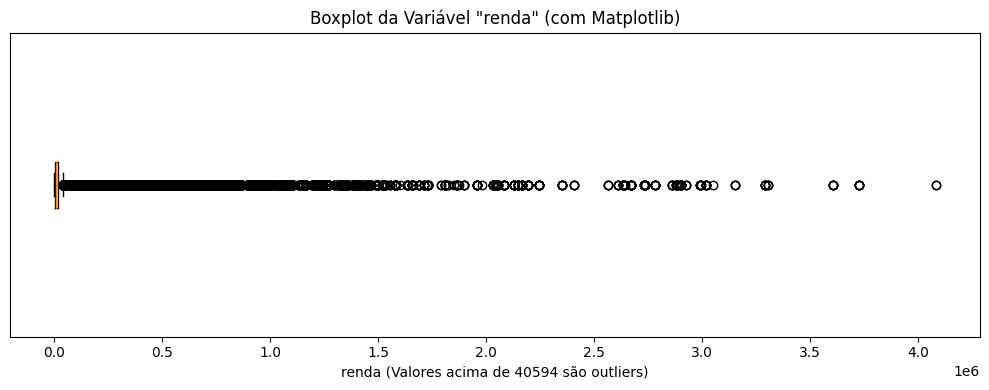

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Removido 'import seaborn as sns'

filename = 'credit_scoring.csv'

try:
    df = pd.read_csv(filename)
    
    print("--- Célula 1: Identificação de Outliers (Método IQR) ---")
    
    col = 'renda'
    
    # 1. Calcular Q1, Q3 e IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # 2. Calcular o limite superior
    limite_superior = Q3 + (1.5 * IQR)
    
    print(f"Analisando a variável: '{col}'")
    print(f"  Quartil 1 (Q1):   {Q1:10.2f}")
    print(f"  Quartil 3 (Q3):   {Q3:10.2f}")
    print(f"  IQR (Q3 - Q1):    {IQR:10.2f}")
    print(f"  Limite Superior (Q3 + 1.5*IQR): {limite_superior:10.2f}")
    
    # 3. Identificar quantos outliers existem
    outliers = df[df[col] > limite_superior]
    
    print(f"\nTotal de registros: {len(df)}")
    print(f"Registros acima do limite (outliers): {len(outliers)}")
    print(f"Percentual de outliers: {len(outliers) / len(df) * 100:.2f}%")
    print(f"Valor Máximo da Renda (Outlier): {df[col].max():10.2f}")

    # 4. Visualização (Boxplot)
    print("\nGerando boxplot (renda_boxplot.png) para visualização...")
    
    plt.figure(figsize=(10, 4))
    
    # --- SUBSTITUIÇÃO DO SEABORN ---
    # Usar plt.boxplot() do matplotlib
    # Usamos vert=False para deitar o gráfico (como o seaborn faria)
    # e limpamos os NaNs da coluna 'renda' apenas para o gráfico
    plt.boxplot(df[col].dropna(), vert=False)
    # --- FIM DA SUBSTITUIÇÃO ---
    
    plt.title(f'Boxplot da Variável "{col}" (com Matplotlib)')
    plt.xlabel(f"{col} (Valores acima de {limite_superior:.0f} são outliers)")
    plt.yticks([]) # Ocultar o '1' no eixo Y
    plt.tight_layout()
    plt.savefig('renda_boxplot.png')
    
    print("Boxplot salvo. Os pontos à direita do 'bigode' são os outliers.")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

In [22]:
import pandas as pd
import numpy as np

try:
    df = pd.read_csv('credit_scoring.csv')
    
    Q1 = df['renda'].quantile(0.25)
    Q3 = df['renda'].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + (1.5 * IQR)
    
    print("--- Célula 2: Substituição de Outliers (Capping) ---")
    print(f"Limite superior calculado: {limite_superior:.2f}")
    
    # Criar uma cópia para não alterar o original
    df_cap = df.copy()
    
    print(f"Valor MÁXIMO da renda ANTES do capping: {df_cap['renda'].max():.2f}")
    
    # Aplicar o Capping:
    df_cap['renda'] = np.where(
        df_cap['renda'] > limite_superior,  # Condição
        limite_superior,                    # Valor se for outlier (substitui)
        df_cap['renda']                     # Valor se não for outlier (mantém)
    )
    
    print(f"Valor MÁXIMO da renda DEPOIS do capping: {df_cap['renda'].max():.2f}")
    
    print("\nDiscussão:")
    print(f"Os {len(df[df['renda'] > limite_superior])} outliers tiveram sua renda 'achatada' para {limite_superior:.2f}.")

except FileNotFoundError:
    print("ERRO: O arquivo 'credit_scoring.csv' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- Célula 2: Substituição de Outliers (Capping) ---
Limite superior calculado: 40594.15
Valor MÁXIMO da renda ANTES do capping: 4083986.22
Valor MÁXIMO da renda DEPOIS do capping: 40594.15

Discussão:
Os 79072 outliers tiveram sua renda 'achatada' para 40594.15.


In [23]:
import pandas as pd
import numpy as np

try:
    df = pd.read_csv('credit_scoring.csv')
    
    Q1 = df['renda'].quantile(0.25)
    Q3 = df['renda'].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + (1.5 * IQR)
    
    print("--- Célula 3: Remoção de Outliers (Dropping) ---")
    
    print(f"Total de registros ANTES da remoção: {len(df)}")
    
    # Manter apenas as linhas onde a renda é MENOR OU IGUAL ao limite
    df_rem = df[df['renda'] <= limite_superior].copy()
    
    print(f"Total de registros DEPOIS da remoção: {len(df_rem)}")
    print(f"Registros perdidos: {len(df) - len(df_rem)}")

    print("\n--- Discussão: Qual a melhor abordagem? ---")
    print("1. Remoção (Dropping):")
    print("   - Contra: Perde informação (perdemos um cliente inteiro da análise).")
    print("   - Quando usar: Apenas se o dado for um ERRO (ex: idade negativa).\n")
    
    print("2. Substituição (Capping):")
    print("   - Pró: Mantém o registro, mas reduz o impacto do outlier.")
    print("   - Contra: Cria um acúmo artificial de valores no limite.\n")
    
    print("3. Transformação (Logaritmo) <- O QUE FIZEMOS NO PIPELINE")
    print("   - Esta é a melhor abordagem para dados financeiros (como 'renda').")
    print("   - Aplicar `np.log1p(df['renda'])` 'comprime' a escala da variável.")
    print("   - Os outliers são 'puxados' para perto da massa de dados, mas sem")
    print("     perder a informação de que eles são maiores que os outros.")

except FileNotFoundError:
    print("ERRO: O arquivo 'credit_scoring.csv' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- Célula 3: Remoção de Outliers (Dropping) ---
Total de registros ANTES da remoção: 750000
Total de registros DEPOIS da remoção: 670928
Registros perdidos: 79072

--- Discussão: Qual a melhor abordagem? ---
1. Remoção (Dropping):
   - Contra: Perde informação (perdemos um cliente inteiro da análise).
   - Quando usar: Apenas se o dado for um ERRO (ex: idade negativa).

2. Substituição (Capping):
   - Pró: Mantém o registro, mas reduz o impacto do outlier.
   - Contra: Cria um acúmo artificial de valores no limite.

3. Transformação (Logaritmo) <- O QUE FIZEMOS NO PIPELINE
   - Esta é a melhor abordagem para dados financeiros (como 'renda').
   - Aplicar `np.log1p(df['renda'])` 'comprime' a escala da variável.
   - Os outliers são 'puxados' para perto da massa de dados, mas sem
     perder a informação de que eles são maiores que os outros.


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO (Pegando apenas TREINO) ---
def carregar_dados_treino(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    print(f"Dados de Treino carregados: {df_train.shape[0]} registros")
    return df_train

# --- 2. FUNÇÃO DE ENGENHARIA DE VARIÁVEIS (A mesma de antes) ---
def engenharia_de_variaveis(df):
    df_eng = df.copy()
    df_eng['renda_log'] = np.log1p(df_eng['renda'])
    df_eng['flag_tem_filhos'] = (df_eng['qtd_filhos'] > 0).astype(int)
    map_educacao = {'Fundamental': 'Fundamental', 'Médio': 'Medio', 'Superior incompleto': 'Superior_ou_mais', 'Superior completo': 'Superior_ou_mais', 'Pós graduação': 'Superior_ou_mais'}
    df_eng['educacao_agrupada'] = df_eng['educacao'].map(map_educacao)
    map_renda = {'Assalariado': 'Assalariado', 'Empresário': 'Empresario', 'Servidor público': 'Servidor_publico', 'Pensionista': 'Pensionista', 'Bolsista': 'Pensionista'}
    df_eng['tipo_renda_agrupado'] = df_eng['tipo_renda'].map(map_renda)
    map_civil = {'Solteiro': 'Solteiro', 'Casado': 'Casado', 'União': 'Uniao', 'Separado': 'Outros', 'Viúvo': 'Outros'}
    df_eng['estado_civil_agrupado'] = df_eng['estado_civil'].map(map_civil)
    map_residencia = {'Casa': 'Casa', 'Aluguel': 'Aluguel', 'Com os pais': 'Outros_moradia', 'Governamental': 'Outros_moradia', 'Estúdio': 'Outros_moradia', 'Comunitário': 'Outros_moradia'}
    df_eng['tipo_residencia_agrupado'] = df_eng['tipo_residencia'].map(map_residencia)
    return df_eng

# --- 3. PREPARAÇÃO DOS DADOS ---
df_train = carregar_dados_treino('credit_scoring.csv')
X_train_eng = engenharia_de_variaveis(df_train)
y_train = X_train_eng['mau'].astype(int).reset_index(drop=True)

features_numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda_log']
features_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'flag_tem_filhos', 'educacao_agrupada', 'tipo_renda_agrupado', 'estado_civil_agrupado', 'tipo_residencia_agrupado']

X_train_model = X_train_eng[features_numericas + features_categoricas]

# --- 4. EXECUTAR O PRÉ-PROCESSAMENTO ---
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numericas),
        ('cat', categorical_transformer, features_categoricas)
    ],
    remainder='drop'
)

# Processar os dados (agora temos um array numpy)
X_train_processed = preprocessor.fit_transform(X_train_model)

# Recuperar os nomes das colunas (CRUCIAL para interpretação)
feature_names_num = preprocessor.named_transformers_['num'].get_feature_names_out()
feature_names_cat = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
all_feature_names = list(feature_names_num) + list(feature_names_cat)

print(f"\nDados pré-processados e prontos para seleção:")
print(f"Shape do X (features): {X_train_processed.shape}")
print(f"Shape do y (alvo): {y_train.shape}")
print(f"Total de features (após dummies): {len(all_feature_names)}")

Dados de Treino carregados: 600000 registros

Dados pré-processados e prontos para seleção:
Shape do X (features): (600000, 18)
Shape do y (alvo): (600000,)
Total de features (após dummies): 18


In [25]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Re-usar os dados processados da Célula 1

print("--- Célula 2: Técnicas de Feature Importance ---")

# --- 1. Importância pelos Coeficientes da Regressão Logística ---
print("\n--- 1. Importância (Coeficientes) da Regressão Logística ---")
# Usamos o valor absoluto (magnitude) do coeficiente como importância
try:
    log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    log_reg.fit(X_train_processed, y_train)
    
    # Extrair coeficientes
    coefs = log_reg.coef_[0]
    
    # Criar DataFrame
    df_coefs = pd.DataFrame({
        'Feature': all_feature_names,
        'Coeficiente': coefs,
        'Importancia (Abs)': np.abs(coefs)
    })
    
    print("Top 10 features (pela magnitude do coeficiente):")
    print(df_coefs.sort_values(by='Importancia (Abs)', ascending=False).head(10).to_string(index=False))
    
except Exception as e:
    print(f"Erro ao calcular importância da Regressão Logística: {e}")


# --- 2. Importância pelo Gini (Random Forest) ---
print("\n--- 2. Importância (Gini) do Random Forest ---")
# Mede o quanto cada feature contribui para a "pureza" dos nós (Gini Impurity)
try:
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_train_processed, y_train)
    
    # Extrair importâncias
    importances_gini = rf.feature_importances_
    
    # Criar DataFrame
    df_gini = pd.DataFrame({
        'Feature': all_feature_names,
        'Importancia (Gini)': importances_gini
    })
    
    print("Top 10 features (pelo Gini Importance):")
    print(df_gini.sort_values(by='Importancia (Gini)', ascending=False).head(10).to_string(index=False))

except Exception as e:
    print(f"Erro ao calcular importância do Random Forest: {e}")

--- Célula 2: Técnicas de Feature Importance ---

--- 1. Importância (Coeficientes) da Regressão Logística ---
Top 10 features (pela magnitude do coeficiente):
            Feature  Coeficiente  Importancia (Abs)
          renda_log      -1.1946             1.1946
           x6_Uniao       0.0621             0.0621
               x1_S       0.0410             0.0410
           x4_Medio       0.0336             0.0336
x4_Superior_ou_mais       0.0279             0.0279
               x3_1       0.0256             0.0256
              idade       0.0198             0.0198
               x2_S      -0.0196             0.0196
        x6_Solteiro       0.0175             0.0175
      tempo_emprego      -0.0174             0.0174

--- 2. Importância (Gini) do Random Forest ---
Top 10 features (pelo Gini Importance):
              Feature  Importancia (Gini)
            renda_log              0.6746
        tempo_emprego              0.1352
                idade              0.0957
qt_pessoas_r

In [26]:
#
# --- Célula 3: Algoritmo de Seleção Boruta (Código de Exemplo) ---
#
# AVISO: Este código NÃO PODE SER EXECUTADO neste ambiente.
# É necessário instalar a biblioteca: pip install boruta_py
#
# Você precisaria dos dados da Célula 1 para executar:
# X_train_processed, y_train, all_feature_names
#

try:
    # 1. Importar as bibliotecas necessárias
    from boruta import BorutaPy
    from sklearn.ensemble import RandomForestClassifier
    
    print("--- Célula 3: Executando o Algoritmo Boruta (Simulação) ---")
    
    # 2. Definir o estimador (Random Forest) que o Boruta usará internamente
    # verbose=2 mostra o progresso, n_jobs=-1 usa todos os cores
    rf_boruta = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                       random_state=42, n_jobs=-1)

    # 3. Inicializar o Boruta
    # perc = 100 (threshold de 100% da melhor sombra)
    # max_iter = 100 (tenta no máximo 100 vezes)
    boruta_selector = BorutaPy(
        estimator=rf_boruta, 
        n_estimators='auto',  # Deixa o boruta decidir o n_estimators
        verbose=2, 
        random_state=42,
        max_iter=100,
        perc=100
    )

    # 4. Treinar o seletor
    # Boruta prefere arrays NumPy, por isso usamos .values (ou o X_train_processed)
    # (Usar .values se y_train for uma Série pandas)
    boruta_selector.fit(X_train_processed, y_train.values)

    # 5. Exibir os resultados
    print("\n--- Resultados do Boruta ---")
    
    # 'support_' lhe dá um booleano [True, False, ...] para features CONFIRMADAS
    features_confirmadas = [
        feature 
        for feature, support 
        in zip(all_feature_names, boruta_selector.support_) 
        if support
    ]

    # 'ranking_' lhe dá a "classificação" (1 = confirmada, >1 = outras)
    ranking = list(zip(all_feature_names, boruta_selector.ranking_))
    ranking_df = pd.DataFrame(ranking, columns=['Feature', 'Ranking (Boruta)'])
    
    print("\nRanking final das features (1 = Confirmada):")
    print(ranking_df.sort_values(by='Ranking (Boruta)'))

    print("\nFeatures CONFIRMADAS pelo Boruta:")
    print(features_confirmadas)

except ModuleNotFoundError:
    print("="*50)
    print("AVISO: Módulo 'boruta' não encontrado.")
    print("O código da Célula 3 é um exemplo e não pôde ser executado.")
    print("Para usá-lo, instale 'pip install boruta_py' em seu ambiente local.")
    print("="*50)
except Exception as e:
    print(f"Ocorreu um erro simulado: {e}")

AVISO: Módulo 'boruta' não encontrado.
O código da Célula 3 é um exemplo e não pôde ser executado.
Para usá-lo, instale 'pip install boruta_py' em seu ambiente local.


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO (Pegando apenas TREINO) ---
def carregar_dados_treino(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    print(f"Dados de Treino carregados: {df_train.shape[0]} registros")
    return df_train

# --- 2. FUNÇÃO DE ENGENHARIA DE VARIÁVEIS (A mesma de antes) ---
def engenharia_de_variaveis(df):
    df_eng = df.copy()
    df_eng['renda_log'] = np.log1p(df_eng['renda'])
    df_eng['flag_tem_filhos'] = (df_eng['qtd_filhos'] > 0).astype(int)
    map_educacao = {'Fundamental': 'Fundamental', 'Médio': 'Medio', 'Superior incompleto': 'Superior_ou_mais', 'Superior completo': 'Superior_ou_mais', 'Pós graduação': 'Superior_ou_mais'}
    df_eng['educacao_agrupada'] = df_eng['educacao'].map(map_educacao)
    map_renda = {'Assalariado': 'Assalariado', 'Empresário': 'Empresario', 'Servidor público': 'Servidor_publico', 'Pensionista': 'Pensionista', 'Bolsista': 'Pensionista'}
    df_eng['tipo_renda_agrupado'] = df_eng['tipo_renda'].map(map_renda)
    map_civil = {'Solteiro': 'Solteiro', 'Casado': 'Casado', 'União': 'Uniao', 'Separado': 'Outros', 'Viúvo': 'Outros'}
    df_eng['estado_civil_agrupado'] = df_eng['estado_civil'].map(map_civil)
    map_residencia = {'Casa': 'Casa', 'Aluguel': 'Aluguel', 'Com os pais': 'Outros_moradia', 'Governamental': 'Outros_moradia', 'Estúdio': 'Outros_moradia', 'Comunitário': 'Outros_moradia'}
    df_eng['tipo_residencia_agrupado'] = df_eng['tipo_residencia'].map(map_residencia)
    return df_eng

# --- 3. PREPARAÇÃO DOS DADOS ---
df_train = carregar_dados_treino('credit_scoring.csv')
X_train_eng = engenharia_de_variaveis(df_train)
y_train = X_train_eng['mau'].astype(int).reset_index(drop=True) # y (alvo)

features_numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda_log']
features_categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'flag_tem_filhos', 'educacao_agrupada', 'tipo_renda_agrupado', 'estado_civil_agrupado', 'tipo_residencia_agrupado']

X_train_model = X_train_eng[features_numericas + features_categoricas]

# --- 4. EXECUTAR O PRÉ-PROCESSAMENTO ---
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_numericas),
        ('cat', categorical_transformer, features_categoricas)
    ],
    remainder='drop'
)

# Processar os dados (agora temos um array numpy)
X_train_processed = preprocessor.fit_transform(X_train_model)

# Recuperar os nomes das colunas
feature_names_num = preprocessor.named_transformers_['num'].get_feature_names_out()
feature_names_cat = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
all_feature_names = list(feature_names_num) + list(feature_names_cat)

print(f"\nDados pré-processados e prontos para PCA:")
print(f"Shape Original (processado): ({X_train_processed.shape[0]}, {len(all_feature_names)})")
print(f"Total de features (após dummies) que entrarão no PCA: {len(all_feature_names)}")

Dados de Treino carregados: 600000 registros

Dados pré-processados e prontos para PCA:
Shape Original (processado): (600000, 18)
Total de features (após dummies) que entrarão no PCA: 18


In [28]:
import numpy as np
from sklearn.decomposition import PCA

# Re-usar os dados processados da Célula 1 (X_train_processed)
try:
    print("\n--- Célula 2: Aplicando o PCA (Análise de Componentes Principais) ---")
    
    # 1. Inicializar o PCA
    # Solicitamos 5 componentes (n_components=5)
    # Adicionamos random_state para garantir reprodutibilidade
    pca = PCA(n_components=5, random_state=42)
    
    # 2. Treinar (fit) e Transformar os dados
    # O 'fit' aprende os eixos de rotação (os componentes)
    # O 'transform' aplica essa rotação, reduzindo os dados
    X_train_pca = pca.fit_transform(X_train_processed)
    
    print("\n--- Resultados da Redução ---")
    print(f"Shape ANTES do PCA: {X_train_processed.shape}")
    print(f"Shape DEPOIS do PCA: {X_train_pca.shape}")
    
    # 3. Analisar a Variância Explicada
    # Esta é a métrica mais importante do PCA
    explained_variance = pca.explained_variance_ratio_
    total_variance = np.sum(explained_variance)
    
    print("\n--- Análise da Variância Explicada ---")
    print(f"Variância Explicada Total (pelos 5 componentes): {total_variance * 100:.2f}%")
    print("--------------------------------------------------")
    print(f"Componente Principal 1 (PC1): {explained_variance[0] * 100:.2f}%")
    print(f"Componente Principal 2 (PC2): {explained_variance[1] * 100:.2f}%")
    print(f"Componente Principal 3 (PC3): {explained_variance[2] * 100:.2f}%")
    print(f"Componente Principal 4 (PC4): {explained_variance[3] * 100:.2f}%")
    print(f"Componente Principal 5 (PC5): {explained_variance[4] * 100:.2f}%")
    print("\nDiscussão:")
    print("O PCA é uma 'compressão'. A % de Variância Explicada Total nos diz quanta")
    print("da informação original (variabilidade dos dados) nós conseguimos manter.")
    print("Se este valor for baixo (ex: < 50%), 5 componentes podem não ser")
    print("suficientes para representar bem os dados originais.")

except NameError:
    print("ERRO: A Célula 1 (Setup e Pré-processamento) não foi executada.")
    print("Por favor, execute a Célula 1 primeiro para preparar os dados.")
except Exception as e:
    print(f"Ocorreu um erro ao aplicar o PCA: {e}")


--- Célula 2: Aplicando o PCA (Análise de Componentes Principais) ---

--- Resultados da Redução ---
Shape ANTES do PCA: (600000, 18)
Shape DEPOIS do PCA: (600000, 5)

--- Análise da Variância Explicada ---
Variância Explicada Total (pelos 5 componentes): 77.04%
--------------------------------------------------
Componente Principal 1 (PC1): 29.43%
Componente Principal 2 (PC2): 23.16%
Componente Principal 3 (PC3): 12.04%
Componente Principal 4 (PC4): 6.68%
Componente Principal 5 (PC5): 5.73%

Discussão:
O PCA é uma 'compressão'. A % de Variância Explicada Total nos diz quanta
da informação original (variabilidade dos dados) nós conseguimos manter.
Se este valor for baixo (ex: < 50%), 5 componentes podem não ser
suficientes para representar bem os dados originais.


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [29]:
import pandas as pd

filename = 'credit_scoring.csv'

# Lista de colunas que você pediu para transformar
colunas_categoricas = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

try:
    # Carregar apenas 10 linhas para o exemplo ficar limpo
    df = pd.read_csv(filename, nrows=10)
    
    print("--- 1. DataFrame ORIGINAL (Antes) ---")
    print(df[colunas_categoricas].head())
    print(f"\nShape Original: {df.shape}")
    print("\n" + "="*60 + "\n")
    
    # --- Aqui é onde a mágica acontece ---
    # Pedimos ao pandas para criar dummies PARA as colunas da lista
    # O restante das colunas (idade, renda, etc.) será mantido
    df_com_dummies = pd.get_dummies(df, columns=colunas_categoricas)
    
    print("--- 2. DataFrame TRANSFORMADO (Depois) ---")
    print(df_com_dummies.head())
    print(f"\nShape com Dummies: {df_com_dummies.shape}")
    
    print("\nObserve como 'sexo' virou 'sexo_F' e 'sexo_M',")
    print("e 'educacao' virou 'educacao_Médio', 'educacao_Superior completo', etc.")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- 1. DataFrame ORIGINAL (Antes) ---
  sexo posse_de_veiculo posse_de_imovel   tipo_renda             educacao estado_civil  \
0    F                N               N   Empresário                Médio     Solteiro   
1    F                S               S  Assalariado                Médio       Casado   
2    F                N               N  Assalariado                Médio       Casado   
3    F                N               N  Assalariado                Médio       Casado   
4    F                S               N  Assalariado  Superior incompleto     Solteiro   

  tipo_residencia  
0            Casa  
1            Casa  
2            Casa  
3            Casa  
4            Casa  

Shape Original: (10, 15)


--- 2. DataFrame TRANSFORMADO (Depois) ---
     data_ref  index  qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia      renda    mau  \
0  2015-01-01   5733           0     43         6.8740                 1.0000  2515.3900  False   
1  2015-01-01    727           0

In [30]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

filename = 'credit_scoring.csv'

colunas_categoricas = [
    'sexo',
    'posse_de_veiculo',
    'posse_de_imovel',
    'tipo_renda',
    'educacao',
    'estado_civil',
    'tipo_residencia'
]

try:
    # Carregar apenas 10 linhas para o exemplo
    df = pd.read_csv(filename, nrows=10)
    
    print("--- 1. DataFrame ORIGINAL (Apenas colunas categóricas) ---")
    print(df[colunas_categoricas].head())
    print("\n" + "="*60 + "\n")
    
    # --- 2. Inicializar o OneHotEncoder ---
    # sparse_output=False: Retorna um array normal (não uma matriz esparsa)
    # handle_unknown='ignore': Se encontrar categoria nova no futuro, ignora (não dá erro)
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # --- 3. Treinar (fit) e Transformar (transform) ---
    # O OHE espera os dados das colunas categóricas
    dados_categoricos = df[colunas_categoricas]
    
    # Aplicamos o fit_transform
    array_dummies = ohe.fit_transform(dados_categoricos)
    
    # --- 4. Recuperar os nomes das colunas ---
    nomes_features = ohe.get_feature_names_out()
    
    # Converter o resultado (array numpy) de volta para um DataFrame
    df_dummies_sklearn = pd.DataFrame(array_dummies, columns=nomes_features)
    
    print("--- 2. DataFrame TRANSFORMADO (pelo OneHotEncoder) ---")
    print(df_dummies_sklearn.head())
    print(f"\nShape com Dummies: {df_dummies_sklearn.shape}")

    # --- 3. DEMONSTRAÇÃO com drop='first' ---
    # (Como fizemos no modelo de Regressão Logística para evitar multicolinearidade)
    
    print("\n" + "="*60 + "\n")
    print("--- 3. OneHotEncoder com 'drop=first' (para Regressão) ---")
    
    ohe_drop = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    array_dummies_drop = ohe_drop.fit_transform(dados_categoricos)
    nomes_features_drop = ohe_drop.get_feature_names_out()
    
    df_dummies_drop = pd.DataFrame(array_dummies_drop, columns=nomes_features_drop)
    print(df_dummies_drop.head())
    print("\nObserve que 'sexo_F' sumiu, pois 'sexo_M=0' já representa 'F'.")


except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")

--- 1. DataFrame ORIGINAL (Apenas colunas categóricas) ---
  sexo posse_de_veiculo posse_de_imovel   tipo_renda             educacao estado_civil  \
0    F                N               N   Empresário                Médio     Solteiro   
1    F                S               S  Assalariado                Médio       Casado   
2    F                N               N  Assalariado                Médio       Casado   
3    F                N               N  Assalariado                Médio       Casado   
4    F                S               N  Assalariado  Superior incompleto     Solteiro   

  tipo_residencia  
0            Casa  
1            Casa  
2            Casa  
3            Casa  
4            Casa  


--- 2. DataFrame TRANSFORMADO (pelo OneHotEncoder) ---
   sexo_F  sexo_M  posse_de_veiculo_N  posse_de_veiculo_S  posse_de_imovel_N  posse_de_imovel_S  \
0  1.0000  0.0000              1.0000              0.0000             1.0000             0.0000   
1  1.0000  0.0000        

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [31]:
import pandas as pd
import numpy as np

# --- 1. FUNÇÃO DE CARREGAMENTO (Pegando apenas TREINO) ---
def carregar_dados_treino(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    # Separação OOT
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    print(f"Dados de Treino carregados: {df_train.shape[0]} registros")
    return df_train

# Carregar os dados de treino
df_train = carregar_dados_treino('credit_scoring.csv')

# --- 2. DEFINIÇÃO DAS COLUNAS PARA O PIPELINE ---

# Colunas para 'substituicao de nulos' (numérica) + Padronização
# (Note: o imputer de mediana não afeta colunas sem nulos, como 'idade')
cols_numericas_com_nulos = [
    'idade', 
    'tempo_emprego',
    'qt_pessoas_residencia'
]

# Coluna para 'remoção outliers' (transformação) + Padronização
col_outlier_renda = 'renda'

# Colunas para 'criação de dummy'
# (Incluindo a 'posse_de_veiculo' obrigatória)
cols_para_dummy = [
    'posse_de_veiculo',
    'sexo',
    'posse_de_imovel'
    # Adicionamos outras colunas categóricas simples
]

# Juntar todas as colunas que o pipeline irá processar
features_usadas = cols_numericas_com_nulos + [col_outlier_renda] + cols_para_dummy
X_train = df_train[features_usadas]
y_train = df_train['mau'].astype(int)

print(f"\nColunas selecionadas para o pipeline: {features_usadas}")
print(f"Shape dos dados de entrada (X_train): {X_train.shape}")

Dados de Treino carregados: 600000 registros

Colunas selecionadas para o pipeline: ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'posse_de_veiculo', 'sexo', 'posse_de_imovel']
Shape dos dados de entrada (X_train): (600000, 7)


In [32]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA

try:
    # --- 1. Sub-pipeline: Substituição de Nulos (Numéricos) e Escala ---
    # (Para 'idade', 'tempo_emprego', 'qt_pessoas_residencia')
    pipeline_numerico = Pipeline(steps=[
        ('substituicao_nulos_num', SimpleImputer(strategy='median')),
        ('scaler_num', StandardScaler())
    ])

    # --- 2. Sub-pipeline: Remoção de Outliers (Transformação) e Escala ---
    # (Para 'renda')
    pipeline_outlier = Pipeline(steps=[
        ('remocao_outliers_log', FunctionTransformer(np.log1p)), # Melhor método
        ('scaler_outlier', StandardScaler())
    ])

    # --- 3. Sub-pipeline: Criação de Dummy (Categóricos) ---
    # (Para 'posse_de_veiculo', 'sexo', 'posse_de_imovel')
    pipeline_categorico = Pipeline(steps=[
        ('substituicao_nulos_cat', SimpleImputer(strategy='most_frequent')),
        ('criacao_dummy', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    # --- 4. Montar o Preprocessador (ColumnTransformer) ---
    # Este objeto aplica os pipelines acima nas colunas corretas
    preprocessador = ColumnTransformer(
        transformers=[
            ('numerico', pipeline_numerico, cols_numericas_com_nulos),
            ('outlier_renda', pipeline_outlier, [col_outlier_renda]), # 'renda'
            ('categorico', pipeline_categorico, cols_para_dummy)
        ],
        remainder='drop' # Ignora colunas não listadas
    )

    # --- 5. Montar o Pipeline Principal ---
    # Este pipeline executa o pré-processamento e, em seguida, o PCA
    pipeline_principal = Pipeline(steps=[
        ('preprocessamento', preprocessador),
        ('pca', PCA(n_components=5, random_state=42)) # Etapa final: PCA
    ])

    # --- 6. Executar o Pipeline ---
    print("\nExecutando o pipeline (fit_transform)...")
    
    # Treinar e transformar os dados X_train
    # O pipeline lida com tudo automaticamente
    X_train_transformado = pipeline_principal.fit_transform(X_train)
    
    print("Pipeline executado com sucesso!")
    
    # --- 7. Resultados ---
    print("\n--- Resultados do Pipeline ---")
    
    # Nomes das colunas após o pré-processamento (antes do PCA)
    num_features = cols_numericas_com_nulos
    out_features = [col_outlier_renda]
    cat_features = pipeline_principal.named_steps['preprocessamento'] \
                                     .named_transformers_['categorico'] \
                                     .named_steps['criacao_dummy'] \
                                     .get_feature_names_out(cols_para_dummy)
    
    total_features_antes_pca = len(num_features) + len(out_features) + len(cat_features)
    
    print(f"Shape ANTES do PCA (mas PÓS-processamento): ({X_train_transformado.shape[0]}, {total_features_antes_pca})")
    print(f"Shape FINAL (PÓS-PCA): {X_train_transformado.shape}")
    
    # Analisar a variância explicada pelo PCA
    pca_obj = pipeline_principal.named_steps['pca']
    total_variance = np.sum(pca_obj.explained_variance_ratio_)
    
    print("\n--- Análise do PCA (Etapa Final) ---")
    print(f"Variância Total Explicada (pelos 5 componentes): {total_variance * 100:.2f}%")
    print(f"Variância por componente: {pca_obj.explained_variance_ratio_ * 100}")

except NameError:
    print("ERRO: A Célula 1 (Setup) não foi executada.")
    print("Por favor, execute a Célula 1 primeiro para preparar os dados (X_train).")
except Exception as e:
    print(f"Ocorreu um erro ao construir ou executar o pipeline: {e}")


Executando o pipeline (fit_transform)...
Pipeline executado com sucesso!

--- Resultados do Pipeline ---
Shape ANTES do PCA (mas PÓS-processamento): (600000, 7)
Shape FINAL (PÓS-PCA): (600000, 5)

--- Análise do PCA (Etapa Final) ---
Variância Total Explicada (pelos 5 componentes): 92.51%
Variância por componente: [37.77357948 27.1868419  13.88181072  7.70582407  5.96226665]


### Treinar um modelo de regressão logistica com o resultado

In [33]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO ---
def carregar_e_separar_dados(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    # Identificar safras OOT (últimos 3 meses)
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    # Separar em Treino e Validação (OOT)
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()
    
    print(f"Dados de Treino carregados: {df_train.shape[0]} registros")
    print(f"Dados de OOT carregados: {df_oot.shape[0]} registros")
    
    return df_train, df_oot

# Carregar os dados
df_train, df_oot = carregar_e_separar_dados('credit_scoring.csv')

# --- 2. DEFINIÇÃO DAS COLUNAS PARA O PIPELINE ---
cols_numericas_com_nulos = ['idade', 'tempo_emprego', 'qt_pessoas_residencia']
col_outlier_renda = 'renda'
cols_para_dummy = ['posse_de_veiculo', 'sexo', 'posse_de_imovel']

features_usadas = cols_numericas_com_nulos + [col_outlier_renda] + cols_para_dummy

# Separar X (features) e y (alvo)
X_train = df_train[features_usadas]
y_train = df_train['mau'].astype(int)

X_oot = df_oot[features_usadas]
y_oot = df_oot['mau'].astype(int)

# --- 3. DEFINIÇÃO DO PIPELINE COMPLETO ---

# Sub-pipelines de pré-processamento
pipeline_numerico = Pipeline(steps=[
    ('substituicao_nulos_num', SimpleImputer(strategy='median')),
    ('scaler_num', StandardScaler())
])
pipeline_outlier = Pipeline(steps=[
    ('remocao_outliers_log', FunctionTransformer(np.log1p)),
    ('scaler_outlier', StandardScaler())
])
pipeline_categorico = Pipeline(steps=[
    ('substituicao_nulos_cat', SimpleImputer(strategy='most_frequent')),
    ('criacao_dummy', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Preprocessador principal (ColumnTransformer)
preprocessador = ColumnTransformer(
    transformers=[
        ('numerico', pipeline_numerico, cols_numericas_com_nulos),
        ('outlier_renda', pipeline_outlier, [col_outlier_renda]),
        ('categorico', pipeline_categorico, cols_para_dummy)
    ],
    remainder='drop'
)

# Pipeline final (Preprocessamento + PCA)
pipeline_principal = Pipeline(steps=[
    ('preprocessamento', preprocessador),
    ('pca', PCA(n_components=5, random_state=42)) # Etapa final: PCA
])

# --- 4. EXECUTAR O PIPELINE ---
print("\nTreinando o pipeline (fit) nos dados de treino...")
# Treinar o pipeline (imputers, scalers, PCA) APENAS nos dados de treino
pipeline_principal.fit(X_train)

print("Transformando dados de Treino e OOT...")
# Aplicar as transformações (incluindo PCA) em ambos os conjuntos
X_train_pca = pipeline_principal.transform(X_train)
X_oot_pca = pipeline_principal.transform(X_oot)

print("\nDados prontos para a Regressão Logística:")
print(f"Shape X_train_pca (Treino): {X_train_pca.shape}")
print(f"Shape X_oot_pca (OOT):    {X_oot_pca.shape}")

Dados de Treino carregados: 600000 registros
Dados de OOT carregados: 150000 registros

Treinando o pipeline (fit) nos dados de treino...
Transformando dados de Treino e OOT...

Dados prontos para a Regressão Logística:
Shape X_train_pca (Treino): (600000, 5)
Shape X_oot_pca (OOT):    (150000, 5)


In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from scipy.stats import ks_2samp
import warnings

# Suprimir warnings
warnings.filterwarnings('ignore')

# Função de Avaliação (A mesma que usamos antes)
def evaluate_metrics(y_true, y_pred_proba, dataset_name):
    """
    Calcula e imprime Acurácia, Gini (AUC) e KS para um conjunto de dados.
    """
    print(f"--- Métricas para {dataset_name} ---")
    
    # --- Acurácia (com limiar/threshold de 0.5) ---
    y_pred_class = (y_pred_proba > 0.5).astype(int)
    accuracy = metrics.accuracy_score(y_true, y_pred_class)
    print(f"Acurácia (limiar 0.5): {accuracy:.4f}")
    
    # --- AUC & Gini ---
    try:
        auc = metrics.roc_auc_score(y_true, y_pred_proba)
        gini = 2 * auc - 1
        print(f"AUC:                    {auc:.4f}")
        print(f"Gini (derivado do AUC): {gini:.4f}")
    except ValueError as e:
        print(f"Não foi possível calcular AUC/Gini: {e}")
        
    # --- KS (Kolmogorov-Smirnov) ---
    probas_bons = y_pred_proba[y_true == 0]
    probas_maus = y_pred_proba[y_true == 1]
    
    if len(probas_bons) > 0 and len(probas_maus) > 0:
        ks_stat, _ = ks_2samp(probas_bons, probas_maus)
        print(f"KS (Kolmogorov-Smirnov): {ks_stat:.4f}")
    else:
        print("Não foi possível calcular o KS (faltam amostras de 'bons' ou 'maus').")
        
    print("-" * 40 + "\n")

# --- 1. Treinar a Regressão Logística ---
try:
    print("\n" + "="*40)
    print("  Treinando Regressão Logística com dados do PCA")
    print("="*40 + "\n")

    # Inicializar o modelo
    # class_weight='balanced' é crucial para dados desbalanceados
    log_reg_pca = LogisticRegression(class_weight='balanced', random_state=42)

    # Treinar o modelo com os 5 componentes do PCA
    log_reg_pca.fit(X_train_pca, y_train)
    
    print("Modelo treinado com sucesso!")
    
    # --- 2. Avaliar o Modelo ---
    print("\n" + "="*40)
    print("      AVALIAÇÃO DE PODER DISCRIMINANTE (PCA)")
    print("="*40 + "\n")
    
    # Gerar predições (probabilidades) no Treino (PCA)
    y_pred_proba_train = log_reg_pca.predict_proba(X_train_pca)[:, 1]
    
    # Gerar predições (probabilidades) no OOT (PCA)
    y_pred_proba_oot = log_reg_pca.predict_proba(X_oot_pca)[:, 1]

    # Avaliar o dataset de Treino (Desenvolvimento)
    evaluate_metrics(y_train, y_pred_proba_train, "Treino (com PCA)")
    
    # Avaliar o dataset de Validação (Out-of-Time)
    evaluate_metrics(y_oot, y_pred_proba_oot, "Validação OOT (com PCA)")
    
except NameError:
    print("ERRO: A Célula 1 (Setup e Pipeline PCA) não foi executada.")
    print("Por favor, execute a Célula 1 primeiro para preparar os dados.")
except Exception as e:
    print(f"Ocorreu um erro ao treinar ou avaliar o modelo: {e}")


  Treinando Regressão Logística com dados do PCA

Modelo treinado com sucesso!

      AVALIAÇÃO DE PODER DISCRIMINANTE (PCA)

--- Métricas para Treino (com PCA) ---
Acurácia (limiar 0.5): 0.6849
AUC:                    0.7695
Gini (derivado do AUC): 0.5390
KS (Kolmogorov-Smirnov): 0.3971
----------------------------------------

--- Métricas para Validação OOT (com PCA) ---
Acurácia (limiar 0.5): 0.3724
AUC:                    0.7382
Gini (derivado do AUC): 0.4764
KS (Kolmogorov-Smirnov): 0.3444
----------------------------------------



### Salvar o pickle file do modelo treinado

In [37]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

print("--- Célula 1: Definição e Treinamento do Pipeline Completo ---")

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO ---
def carregar_e_separar_dados(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()
    
    return df_train, df_oot

# Carregar os dados
try:
    df_train, df_oot = carregar_e_separar_dados('credit_scoring.csv')

    # --- 2. DEFINIÇÃO DAS COLUNAS PARA O PIPELINE ---
    cols_numericas_com_nulos = ['idade', 'tempo_emprego', 'qt_pessoas_residencia']
    col_outlier_renda = 'renda'
    cols_para_dummy = [
        'sexo', 'posse_de_veiculo', 'posse_de_imovel', 
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ]
    features_usadas = cols_numericas_com_nulos + [col_outlier_renda] + cols_para_dummy

    # Separar X (features) e y (alvo)
    X_train = df_train[features_usadas]
    y_train = df_train['mau'].astype(int)

    # Dados brutos de OOT (para teste na Célula 3)
    X_oot_raw = df_oot[features_usadas]
    y_oot_raw = df_oot['mau'].astype(int)

    # --- 3. DEFINIÇÃO DO PIPELINE COMPLETO (Pré-processamento + PCA + Modelo) ---
    pipeline_numerico = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    pipeline_outlier = Pipeline(steps=[('transformer', FunctionTransformer(np.log1p)), ('scaler', StandardScaler())])
    pipeline_categorico = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])

    preprocessador = ColumnTransformer(
        transformers=[
            ('numerico', pipeline_numerico, cols_numericas_com_nulos),
            ('outlier_renda', pipeline_outlier, [col_outlier_renda]),
            ('categorico', pipeline_categorico, cols_para_dummy)
        ],
        remainder='drop'
    )

    # --- 4. CORREÇÃO DO NOME DA VARIÁVEL ---
    # O pipeline final agora se chama 'model'
    model = Pipeline(steps=[
        ('preprocessamento', preprocessador),
        ('pca', PCA(n_components=5, random_state=42)),
        ('modelo_logistico', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ])

    # --- 5. TREINAR O PIPELINE COMPLETO ---
    print("\nTreinando o pipeline (fit) nos dados de treino (X_train, y_train)...")
    model.fit(X_train, y_train)
    print("Treinamento concluído. O objeto 'model' está pronto.")
    print("Os objetos 'X_oot_raw' e 'y_oot_raw' também estão prontos para a Célula 3.")

except FileNotFoundError:
    print("ERRO: O arquivo 'credit_scoring.csv' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro na Célula 1: {e}")

--- Célula 1: Definição e Treinamento do Pipeline Completo ---

Treinando o pipeline (fit) nos dados de treino (X_train, y_train)...
Treinamento concluído. O objeto 'model' está pronto.
Os objetos 'X_oot_raw' e 'y_oot_raw' também estão prontos para a Célula 3.


In [38]:
import pickle

# Esta célula espera que 'model' tenha sido definida na Célula 1
try:
    nome_arquivo = 'model_final.pkl'
    with open(nome_arquivo, 'wb') as file:
        pickle.dump(model, file)
        
    print(f"Modelo salvo com sucesso no arquivo: {nome_arquivo}")

except NameError:
    print("ERRO: A variável 'model' não foi definida.")
    print("Por favor, execute a Célula 1 (Treinamento) primeiro.")
except Exception as e:
    print(f"Ocorreu um erro ao salvar o pickle: {e}")

Modelo salvo com sucesso no arquivo: model_final.pkl


In [39]:
import pickle
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

# Esta célula espera que 'X_oot_raw' e 'y_oot_raw' tenham sido definidos na Célula 1
print("--- Célula 3: Carregando e Testando o Modelo Salvo ---")

try:
    nome_arquivo = 'model_final.pkl'
    with open(nome_arquivo, 'rb') as file:
        loaded_model = pickle.load(file)
        
    print(f"Modelo '{nome_arquivo}' carregado com sucesso.")
    
    # Testar o modelo carregado nos dados OOT (brutos)
    print(f"\nTestando o modelo carregado nos dados de OOT...")
    
    y_pred_oot_proba = loaded_model.predict_proba(X_oot_raw)[:, 1]
    
    print("Predições no OOT realizadas com sucesso.")
    
    # Calcular métricas no OOT
    auc = roc_auc_score(y_oot_raw, y_pred_oot_proba)
    gini = 2 * auc - 1
    ks, _ = ks_2samp(y_pred_oot_proba[y_oot_raw == 0], y_pred_oot_proba[y_oot_raw == 1])
    
    print("\nMétricas de avaliação no OOT (usando modelo carregado):")
    print(f"  Gini: {gini:.4f}")
    print(f"  KS:   {ks:.4f}")

except FileNotFoundError:
    print(f"ERRO: O arquivo '{nome_arquivo}' não foi encontrado.")
    print("Por favor, execute a Célula 2 (Salvando) primeiro.")
except NameError:
    print("ERRO: As variáveis 'X_oot_raw' ou 'y_oot_raw' não foram definidas.")
    print("Por favor, execute a Célula 1 (Treinamento) primeiro.")
except Exception as e:
    print

--- Célula 3: Carregando e Testando o Modelo Salvo ---
Modelo 'model_final.pkl' carregado com sucesso.

Testando o modelo carregado nos dados de OOT...
Predições no OOT realizadas com sucesso.

Métricas de avaliação no OOT (usando modelo carregado):
  Gini: 0.4729
  KS:   0.3435


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [2]:
import pandas as pd
from pycaret.classification import *

# 1. Carregar o arquivo de dados
filename = 'credit_scoring.csv'
try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print(f"ERRO: O arquivo '{filename}' não foi encontrado.")
    # Se der este erro, pare e faça o upload do 'credit_scoring.csv'

# 2. Preparar dados (datas e ordenação)
df['data_ref'] = pd.to_datetime(df['data_ref'])
df = df.sort_values(by='data_ref')

# 3. Separar Treino e OOT (Out-of-Time)
datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
safras_oot = datas_safra[-3:]
data_inicio_oot = safras_oot[0].to_timestamp()

# Dados para treinar o PyCaret (onde o erro aconteceu)
train_data = df[df['data_ref'] < data_inicio_oot].copy()
oot_data = df[df['data_ref'] >= data_inicio_oot].copy()

print(f"Shape dos Dados de Treino (para o PyCaret): {train_data.shape}")
print(f"Shape dos Dados de OOT (para teste final): {oot_data.shape}")

# 4. Configurar o ambiente PyCaret (Setup)
print("\nConfigurando o ambiente PyCaret (setup)...")
# Usando 'log_experiment=False' para evitar o erro anterior do MLflow
clf_setup = setup(
    data=train_data,
    target='mau',
    
    # Ignorar colunas de ID e data
    ignore_features=['index', 'data_ref'],
    
    # Configurar pré-processamento
    imputation_type='simple',
    numeric_imputation='median',
    categorical_imputation='mode',
    transformation=True,
    outliers_threshold=0.05,
    fix_imbalance=True,
    
    # Configuração do experimento
    session_id=42,
    log_experiment=False, # Evita o erro do MLflow
    experiment_name='credit_scoring_lgbm'
)

print("\nSetup do PyCaret concluído.")
print("O pré-processamento está pronto. Você já pode rodar a Célula 2.")

Shape dos Dados de Treino (para o PyCaret): (600000, 15)
Shape dos Dados de OOT (para teste final): (150000, 15)

Configurando o ambiente PyCaret (setup)...


,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(600000, 15)"
4,Transformed data shape,"(968700, 30)"
5,Transformed train set shape,"(788700, 30)"
6,Transformed test set shape,"(180000, 30)"
7,Ignore features,2
8,Numeric features,5
9,Categorical features,7



Setup do PyCaret concluído.
O pré-processamento está pronto. Você já pode rodar a Célula 2.


In [4]:
import matplotlib.pyplot as plt

# (Esta célula deve ser executada após a Célula 1)
try:
    # 1. Criar o modelo LightGBM (Isto é rápido)
    print("\n--- 1. Criando o modelo LightGBM (lgbm) ---")
    lgbm = create_model('lightgbm')
    
    # 2. Otimizar (Tuning) o modelo LightGBM [ETAPA PULADA]
    # Esta é a etapa demorada. Vamos pulá-la para acelerar.
    print("\n--- 2. Otimizando (Tuning) o modelo lgbm [PULADO PARA VELOCIDADE] ---")
    # tuned_lgbm = tune_model(lgbm) # LINHA REMOVIDA
    
    # IMPORTANTE: Vamos usar o modelo 'lgbm' (não tunado)
    # nas etapas seguintes.
    model_to_use = lgbm
    
    # 3. Gerar os Gráficos Finais (usando o modelo base 'lgbm')
    print("\n--- 3. Gerando Gráficos de Avaliação (Modelo Base) ---")
    
    # Salva a Curva ROC (AUC)
    plot_model(model_to_use, plot='auc', save=True)
    print("Gráfico 'AUC.png' salvo.")
    
    # Salva a Matriz de Confusão
    plot_model(model_to_use, plot='confusion_matrix', save=True)
    print("Gráfico 'Confusion Matrix.png' salvo.")
    
    # Salva o KS Stat (essencial em scoring)
    plot_model(model_to_use, plot='ks', save=True)
    print("Gráfico 'KS Plot.png' salvo.")

    # Salva a Importância das Variáveis (Feature Importance)
    plot_model(model_to_use, plot='feature', save=True)
    print("Gráfico 'Feature Importance.png' salvo.")

    # 4. Avaliar o modelo nos dados Out-of-Time (OOT)
    # (Usando o modelo base 'lgbm')
    print("\n--- 4. Avaliando o modelo (Base) nos dados Out-of-Time (OOT) ---")
    
    # Certifique-se que 'oot_data' foi criada na Célula 1
    oot_predictions = predict_model(model_to_use, data=oot_data)
    
    print("\nResultados (Métricas) no OOT:")
    print(oot_predictions[['index', 'mau', 'prediction_score', 'prediction_label']].head())
    
    # 5. Finalizar o modelo
    print("\n--- 5. Finalizando o modelo (treinando com dados completos) ---")
    final_lgbm = finalize_model(model_to_use)
    
    # 6. Salvar o Pipeline Completo (Pré-processamento + Modelo)
    print("\n--- 6. Salvando o pipeline completo ---")
    pipeline_filename = 'lgbm_pipeline_pycaret'
    save_model(final_lgbm, pipeline_filename)
    
    print(f"\nPipeline completo (pré-processamento + modelo base lgbm) salvo como:")
    print(f"'{pipeline_filename}.pkl'")

except NameError as e:
    print(f"Ocorreu um erro: {e}")
    print("Certifique-se de que a Célula 1 foi executada com sucesso E")
    print("que as variáveis 'oot_data' e 'lgbm' existem.")
except Exception as e:
    print(f"Ocorreu um erro: {e}")
    print("Certifique-se de que a Célula 1 foi executada com sucesso.")


--- 1. Criando o modelo LightGBM (lgbm) ---


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9263,0.7671,0.1435,0.2907,0.1921,0.1581,0.1690
1,0.9258,0.7735,0.1411,0.2841,0.1886,0.1543,0.1648
2,0.9274,0.7581,0.1485,0.3060,0.2000,0.1667,0.1788
3,0.9269,0.7716,0.1489,0.3006,0.1992,0.1654,0.1767
4,0.9277,0.7655,0.1532,0.3124,0.2056,0.1723,0.1844
5,0.9260,0.7628,0.1411,0.2855,0.1889,0.1547,0.1654
6,0.9273,0.7668,0.1552,0.3095,0.2067,0.1730,0.1844
7,0.9266,0.7654,0.1505,0.2995,0.2003,0.1663,0.1771
8,0.9277,0.7747,0.1411,0.3024,0.1925,0.1598,0.1726



--- 2. Otimizando (Tuning) o modelo lgbm [PULADO PARA VELOCIDADE] ---

--- 3. Gerando Gráficos de Avaliação (Modelo Base) ---


Gráfico 'AUC.png' salvo.


Gráfico 'Confusion Matrix.png' salvo.


Gráfico 'KS Plot.png' salvo.


Gráfico 'Feature Importance.png' salvo.

--- 4. Avaliando o modelo (Base) nos dados Out-of-Time (OOT) ---


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7847,0.7353,0.4410,0.3266,0.3753,0.2487,0.2528



Resultados (Métricas) no OOT:
        index    mau  prediction_score  prediction_label
633328  14658  False            0.7379                 0
633329  15501  False            0.5554                 0
633330   6093  False            0.8834                 0
633331     29  False            0.6634                 1
633332   8359   True            0.5972                 1

--- 5. Finalizando o modelo (treinando com dados completos) ---

--- 6. Salvando o pipeline completo ---
Transformation Pipeline and Model Successfully Saved

Pipeline completo (pré-processamento + modelo base lgbm) salvo como:
'lgbm_pipeline_pycaret.pkl'


In [5]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [6]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [7]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9263,0.7671,0.1435,0.2907,0.1921,0.1581,0.1690
1,0.9258,0.7735,0.1411,0.2841,0.1886,0.1543,0.1648
2,0.9274,0.7581,0.1485,0.3060,0.2000,0.1667,0.1788
3,0.9269,0.7716,0.1489,0.3006,0.1992,0.1654,0.1767
4,0.9277,0.7655,0.1532,0.3124,0.2056,0.1723,0.1844
5,0.9260,0.7628,0.1411,0.2855,0.1889,0.1547,0.1654
6,0.9273,0.7668,0.1552,0.3095,0.2067,0.1730,0.1844
7,0.9266,0.7654,0.1505,0.2995,0.2003,0.1663,0.1771
8,0.9277,0.7747,0.1411,0.3024,0.1925,0.1598,0.1726


### Salvar o arquivo do modelo treinado

In [8]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

print("--- Célula 1: Carregando Dados e Bibliotecas ---")

# --- 1. FUNÇÃO DE CARREGAMENTO E SEPARAÇÃO ---
def carregar_e_separar_dados(filename='credit_scoring.csv'):
    df = pd.read_csv(filename)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    df = df.sort_values(by='data_ref')
    
    datas_safra = sorted(df['data_ref'].dt.to_period('M').unique())
    safras_oot = datas_safra[-3:]
    data_inicio_oot = safras_oot[0].to_timestamp()
    
    df_train = df[df['data_ref'] < data_inicio_oot].copy()
    df_oot = df[df['data_ref'] >= data_inicio_oot].copy()
    
    return df_train, df_oot

# Carregar os dados
try:
    df_train, df_oot = carregar_e_separar_dados('credit_scoring.csv')
    print("Dados carregados e separados com sucesso.")
    print(f"Shape Treino: {df_train.shape}")
    print(f"Shape OOT:    {df_oot.shape}")

except FileNotFoundError:
    print("ERRO: O arquivo 'credit_scoring.csv' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro na Célula 1: {e}")

--- Célula 1: Carregando Dados e Bibliotecas ---
Dados carregados e separados com sucesso.
Shape Treino: (600000, 15)
Shape OOT:    (150000, 15)


In [9]:
# (Execute esta célula após a Célula 1)
try:
    print("--- Célula 2: Definindo o Pipeline (Modelo) ---")
    
    # --- 1. DEFINIÇÃO DAS COLUNAS PARA O PIPELINE ---
    cols_numericas_com_nulos = ['idade', 'tempo_emprego', 'qt_pessoas_residencia']
    col_outlier_renda = 'renda'
    cols_para_dummy = [
        'sexo', 'posse_de_veiculo', 'posse_de_imovel', 
        'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'
    ]
    features_usadas = cols_numericas_com_nulos + [col_outlier_renda] + cols_para_dummy

    # Separar X (features) e y (alvo)
    X_train = df_train[features_usadas]
    y_train = df_train['mau'].astype(int)
    
    # (Reservar OOT para teste na Célula 4)
    X_oot_raw = df_oot[features_usadas]
    y_oot_raw = df_oot['mau'].astype(int)

    # --- 2. DEFINIÇÃO DO PIPELINE COMPLETO ---
    pipeline_numerico = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    pipeline_outlier = Pipeline(steps=[('transformer', FunctionTransformer(np.log1p)), ('scaler', StandardScaler())])
    pipeline_categorico = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])

    preprocessador = ColumnTransformer(
        transformers=[
            ('numerico', pipeline_numerico, cols_numericas_com_nulos),
            ('outlier_renda', pipeline_outlier, [col_outlier_renda]),
            ('categorico', pipeline_categorico, cols_para_dummy)
        ],
        remainder='drop'
    )

    # --- 3. A VARIÁVEL 'model' É CRIADA AQUI ---
    model = Pipeline(steps=[
        ('preprocessamento', preprocessador),
        ('pca', PCA(n_components=5, random_state=42)),
        ('modelo_logistico', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
    ])
    
    print("Variável 'model' (pipeline não treinado) criada com sucesso.")
    
except NameError as e:
    print(f"ERRO: {e}")
    print("Certifique-se de que a Célula 1 foi executada com sucesso.")
except Exception as e:
    print(f"Ocorreu um erro na Célula 2: {e}")

--- Célula 2: Definindo o Pipeline (Modelo) ---
Variável 'model' (pipeline não treinado) criada com sucesso.


In [10]:
# (Execute esta célula após a Célula 2)
try:
    print("--- Célula 3: Treinando o Modelo ---")
    
    # 'model', 'X_train', 'y_train' foram definidos na Célula 2
    model.fit(X_train, y_train)
    
    print("Treinamento concluído com sucesso.")
    print("A variável 'model' agora contém o pipeline treinado.")
    
except NameError as e:
    print(f"ERRO: {e}")
    print("Certifique-se de que a Célula 2 foi executada com sucesso.")
except Exception as e:
    print(f"Ocorreu um erro na Célula 3: {e}")

--- Célula 3: Treinando o Modelo ---
Treinamento concluído com sucesso.
A variável 'model' agora contém o pipeline treinado.


In [11]:
import pickle

# (Execute esta célula após a Célula 3)
try:
    print("--- Célula 4: Salvando o Modelo Treinado ---")
    
    nome_arquivo = 'model_final.pkl'
    with open(nome_arquivo, 'wb') as file:
        # A variável 'model' (treinada na Célula 3) é salva
        pickle.dump(model, file)
        
    print(f"Modelo salvo com sucesso no arquivo: {nome_arquivo}")

    # Teste rápido (opcional): Carregar e testar no OOT
    print("\nTestando o arquivo salvo...")
    with open(nome_arquivo, 'rb') as file:
        loaded_model_test = pickle.load(file)
    
    # 'X_oot_raw' foi definido na Célula 2
    pred_oot = loaded_model_test.predict_proba(X_oot_raw)[:, 1]
    print(f"Modelo carregado fez {len(pred_oot)} predições no OOT com sucesso.")

except NameError as e:
    print(f"ERRO: {e}")
    print("Certifique-se de que a Célula 3 foi executada com sucesso.")
except Exception as e:
    print(f"Ocorreu um erro na Célula 4: {e}")

--- Célula 4: Salvando o Modelo Treinado ---
Modelo salvo com sucesso no arquivo: model_final.pkl

Testando o arquivo salvo...
Modelo carregado fez 150000 predições no OOT com sucesso.


# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.